<a href="https://colab.research.google.com/github/EdWangLoDaSc/Physical-based-Spatial-time-series-Prediction/blob/main/0130%E8%BF%98%E4%B8%8D%E9%94%99.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
from scipy.interpolate import griddata


import time
from pylab import *
import matplotlib.gridspec as gridspec
import pandas as pd
from scipy.interpolate import griddata

# -*- coding: utf-8 -*-
import numpy as np
import scipy
import math
import matplotlib.pyplot as plt

from matplotlib import cm
from matplotlib import animation as animation

from PIL import Image
import matplotlib as mpl

import pickle

from sklearn.preprocessing import MinMaxScaler,StandardScaler
import random as rand
from sklearn.model_selection import train_test_split
#from skimage.metrics import structural_similarity as ssim
from skimage.metrics import structural_similarity as ssim



# Install

In [2]:
def x_to_y(X): # averaging in 2*2 windows (4 pixels)
    dim = X.shape[0]
    dim = 20
    Y = np.zeros((int(dim/2),int(dim/2)))
    for i in range(int(dim/2)):
        for j in range(int(dim/2)):
            Y[i,j] = X[2*i,2*j] + X[2*i+1,2*j] + X[2*i,2*j+1] + X[2*i+1,2*j+1]

            Y_noise = np.random.multivariate_normal(np.zeros(100),0.0000 * np.eye(100))
            Y_noise.shape = (10,10)
            Y = Y + Y_noise
    return Y


class shallow(object):

    time = 0

    plt = []
    fig = []


    def __init__(self, x=[],y=[],h_ini = 1.,u=[],v = [],dx=0.01,dt=0.0001, N=64,L=1., px=16, py=16, R=64, Hp=0.1, g=1., b=0.): # How define no default argument before?


        # add a perturbation in pressure surface


        self.px, self.py = px, py
        self.R = R
        self.Hp = Hp



        # Physical parameters

        self.g = g
        self.b = b
        self.L=L
        self.N=N

        self.dx=dx
        self.dt=dt

        self.x,self.y = mgrid[:self.N,:self.N]

        self.u=zeros((self.N,self.N))
        self.v=zeros((self.N,self.N))

        self.h_ini=h_ini

        self.h=self.h_ini * ones((self.N,self.N))

        rr = (self.x-px)**2 + (self.y-py)**2
        self.h[rr<R] = self.h_ini + Hp #set initial conditions

        self.lims = [(self.h_ini-self.Hp,self.h_ini+self.Hp),(-0.02,0.02),(-0.02,0.02)]



    def dxy(self, A, axis=0):
        """
        Compute derivative of array A using balanced finite differences
        Axis specifies direction of spatial derivative (d/dx or d/dy)
        dA[i]/dx =  (A[i+1] - A[i-1] )  / 2dx
        """
        return (roll(A, -1, axis) - roll(A, 1, axis)) / (self.dx*2.) # roll: shift the array axis=0 shift the horizontal axis

    def d_dx(self, A):
        return self.dxy(A,1)

    def d_dy(self, A):
        return self.dxy(A,0)


    def d_dt(self, h, u, v):
        """
        http://en.wikipedia.org/wiki/Shallow_water_equations#Non-conservative_form
        """
        for x in [h, u, v]: # type check
           assert isinstance(x, ndarray) and not isinstance(x, matrix)

        g,b,dx = self.g, self.b, self.dx

        du_dt = -g*self.d_dx(h) - b*u
        dv_dt = -g*self.d_dy(h) - b*v

        H = 0 #h.mean() - our definition of h includes this term
        dh_dt = -self.d_dx(u * (H+h)) - self.d_dy(v * (H+h))

        return dh_dt, du_dt, dv_dt


    def evolve(self):
        """
        Evolve state (h, u, v) forward in time using simple Euler method
        x_{N+1} = x_{N} +   dx/dt * d_t
        """

        dh_dt, du_dt, dv_dt = self.d_dt(self.h, self.u, self.v)
        dt = self.dt

        self.h += dh_dt * dt
        self.u += du_dt * dt
        self.v += dv_dt * dt
        self.time += dt

        return self.h, self.u, self.v

In [3]:
import random as rand
def simu(iteration_times, Hp, R, n_steps,blank_steps, px, py):
    SW = shallow(N=64, px=px, py=py, R=R, Hp=Hp, b=0.2)
    num = (iteration_times - blank_steps) // n_steps
    true_u_vect = np.zeros((num, SW.N, SW.N))
    true_v_vect = np.zeros((num, SW.N, SW.N))
    true_h_vect = np.zeros((num, SW.N, SW.N))
    index = 0

    for i in range(iteration_times):
        SW.evolve()

        if i % n_steps == 0 and i > 600:
            true_u_vect[index], true_v_vect[index], true_h_vect[index] = SW.u, SW.v, SW.h
            index += 1

    return true_u_vect, true_v_vect, true_h_vect


def structure_obs(N, random_range):
    x = np.arange(0, N, 5)
    y = np.arange(0, N, 5)
    x_list, y_list = np.meshgrid(x, y)

    x_coord = np.empty(x_list.size, dtype=int)
    y_coord = np.empty(y_list.size, dtype=int)

    for i, (x_val, y_val) in enumerate(zip(x_list.flatten(), y_list.flatten())):
        if (i+1) % 64 != 0:
            x_val += rand.randint(0, random_range)
            y_val += rand.randint(0, random_range)

        x_coord[i] = x_val if x_val < N else N - 1
        y_coord[i] = y_val if y_val < N else N - 1

    return x_coord, y_coord

def normalize_and_index(data, index):

  data_norm = (data - np.min(data)) / (np.max(data) - np.min(data))

  data_indexed = np.expand_dims(data_norm[index], axis=-1)
  #data_indexed = np.expand_dims(data[index], axis=-1)

  interval =(np.max(data) - np.min(data))
  return data_indexed, (np.max(data) - np.min(data)),np.min(data)

In [4]:
import random

#random.seed(12)
random.seed(144)
second_element_range = (0.1, 1.0)
third_element_range = (4, 16)

# Number of random tuples to generate
num_random_tuples = 150
steps = 3600
blank_steps = 600
px = 32
py = 32
# Generate random tuples
sim_params = [(steps,
               round(random.uniform(*second_element_range), 2),
               random.randint(*third_element_range),
               10,
               blank_steps,
               px,#np.random.randint(30, 34),  # px
               py)#random.randint(30, 34))  # py
              for _ in range(num_random_tuples)]
# Simulate data and stack the results
def simulate_and_stack(sim_params):
    true_u_vect, true_v_vect, true_h_vect = [], [], []
    for nsteps, hp, r, n,blank,px,py in sim_params:
        u, v, h = simu(nsteps, hp, r**2, n,blank,px,py)
        true_u_vect.append(u)
        true_v_vect.append(v)
        true_h_vect.append(h)

    true_u_vect = np.vstack(true_u_vect)
    true_v_vect = np.vstack(true_v_vect)
    true_h_vect = np.vstack(true_h_vect)

    return true_u_vect, true_v_vect, true_h_vect

# Simulate data and stack the results
true_u_vect, true_v_vect, true_h_vect = simulate_and_stack(sim_params)

# Generate structure observations
x_coord, y_coord = structure_obs(64, 2)


In [6]:
np.save('/content/0121/true_u_full.npy',true_u_vect)
np.save('/content/0121/true_v_full.npy',true_v_vect)
np.save('/content/0121/true_h_full.npy',true_h_vect)
del true_u_vect,true_v_vect,true_h_vect

In [7]:
import numpy as np
from scipy.interpolate import griddata

# Load data
true_u_vect = np.load('/content/0121/true_u_full.npy', mmap_mode="r")
true_v_vect = np.load('/content/0121/true_v_full.npy', mmap_mode="r")
true_h_vect = np.load('/content/0121/true_h_full.npy', mmap_mode="r")

a = (steps-blank_steps)/10 * num_random_tuples


# Constants
N = 64
datasize = int(a)  # Ensure 'a' is defined earlier in your code

# Initialize arrays
true_data = np.zeros((datasize, N, N, 3))  # Combining u, v, h data into one array for simplicity
vor_data = np.zeros((datasize, N, N, 3))

# Grid preparation
x, y = np.linspace(0., N, N), np.linspace(0., N, N)[::-1]
X, Y = np.meshgrid(x, y)
P = np.column_stack((X.flatten(), Y.flatten()))

# Data processing
for index in range(datasize):
    for vect, slice_idx in zip([true_u_vect, true_v_vect, true_h_vect], range(3)):
        Zi = vect[index, x_coord.astype(int), N-1-y_coord.astype(int)]
        Pi = np.column_stack((x_coord, y_coord))
        Z_nearest = griddata(Pi, Zi, P, method="nearest").reshape([N, N])
        vor_data[index, :, :, slice_idx] = Z_nearest
        true_data[index, :, :, slice_idx] = vect[index, :, :]

# Correcting the data swap issue
vor_u_data, vor_v_data = vor_data[..., 0], vor_data[..., 1]
vor_h_data, true_u_data = vor_data[..., 2], true_data[..., 0]
true_v_data, true_h_data = true_data[..., 1], true_data[..., 2]

print(true_u_data.shape)
print(true_u_vect.shape)
# Save data
np.save('/content/0121/vor_u_full.npy', vor_u_data)
np.save('/content/0121/vor_v_full.npy', vor_v_data)
np.save('/content/0121/vor_h_full.npy', vor_h_data)


# Clean up
del vor_u_data, vor_v_data, vor_h_data, true_u_data, true_v_data, true_h_data
del true_u_vect, true_v_vect, true_h_vect


(45000, 64, 64)
(45000, 64, 64)


#### Origin

In [ ]:
true_u_vect = np.load('/content/true_u_vect.npy', mmap_mode="r")
true_v_vect = np.load('/content/true_v_vect.npy', mmap_mode="r")
true_h_vect = np.load('/content/true_h_vect.npy', mmap_mode="r")

N = 64
datasize = int(a)

true_u_data = np.zeros((datasize, N, N))
true_v_data = np.zeros((datasize, N, N))
true_h_data = np.zeros((datasize, N, N))

vor_u_data = np.zeros((datasize, N, N))
vor_v_data = np.zeros((datasize, N, N))
vor_h_data = np.zeros((datasize, N, N))

x = np.linspace(0., N, N)
y = np.linspace(0., N, N)[::-1]
X, Y = np.meshgrid(x, y)
P = np.column_stack((X.flatten(), Y.flatten()))

count = 0
for index in range(datasize):
    for repeat in range(1):
        u_t = true_u_vect[index, :, :]
        v_t = true_v_vect[index, :, :]
        h_t = true_h_vect[index, :, :]

        u_Zi = u_t[x_coord.astype(int), N-1-y_coord.astype(int)]
        v_Zi = v_t[x_coord.astype(int), N-1-y_coord.astype(int)]
        h_Zi = h_t[x_coord.astype(int), N-1-y_coord.astype(int)]

        Pi = np.column_stack((x_coord, y_coord))
        u_Z_nearest = griddata(Pi, u_Zi, P, method="nearest").reshape([N, N])
        v_Z_nearest = griddata(Pi, v_Zi, P, method="nearest").reshape([N, N])
        h_Z_nearest = griddata(Pi, h_Zi, P, method="nearest").reshape([N, N])

        vor_u_data[count, :, :] = u_Z_nearest
        vor_v_data[count, :, :] = v_Z_nearest
        vor_h_data[count, :, :] = h_Z_nearest

        true_u_data[count, :, :] = u_t
        true_v_data[count, :, :] = v_t
        true_h_data[count, :, :] = h_t

        count += 1

vor_u = vor_u_data
vor_u_data = vor_v_data
vor_v_data = vor_u



np.save('/content/vor_u_data.npy',vor_u_data)
np.save('/content/vor_v_data.npy',vor_v_data)
np.save('/content/vor_h_data.npy',vor_h_data)
np.save('/content/true_u_data.npy',true_u_data)
np.save('/content/true_v_data.npy',true_v_data)
np.save('/content/true_h_data.npy',true_h_data)
del vor_u_data,vor_v_data,vor_h_data,true_u_data,true_v_data, true_h_data,true_u_vect,true_v_vect,true_h_vect


#### continue

In [8]:
vor_u_data = np.load('/content/0121/vor_u_full.npy', mmap_mode="r")
vor_v_data = np.load('/content/0121/vor_v_full.npy', mmap_mode="r")
vor_h_data = np.load('/content/0121/vor_h_full.npy', mmap_mode="r")
true_v_data = np.load('/content/0121/true_v_full.npy', mmap_mode="r")
true_u_data = np.load('/content/0121/true_u_full.npy', mmap_mode="r")
true_h_data = np.load('/content/0121/true_h_full.npy', mmap_mode="r")


#### CAE+LSTM Datasets Creation

In [9]:

# Create train and test indices
train_rate = 0.9
train_index = np.arange(0, int(datasize * train_rate))
test_index = np.arange(train_index[-1] + 1, datasize)

# Data categories
data_types = ['u', 'v', 'h']
vor_data = [vor_u_data, vor_v_data,vor_h_data]
true_data = [true_v_data,true_u_data,true_h_data]

# Initialize lists to store the split datasets
vor_train, vor_test, true_train, true_test = [], [], [], []

# Processing loop
for vor, true in zip(vor_data, true_data):
    # Split vor data
    vor_train.append(vor[train_index])
    vor_test.append(vor[test_index])

    # Split true data
    true_train.append(true[train_index])
    true_test.append(true[test_index])

# Final concatenation
vor_train = np.stack(vor_train, axis=-1)
true_train = np.stack(true_train, axis=-1)
vor_test = np.stack(vor_test, axis=-1)
true_test = np.stack(true_test, axis=-1)


# Now you can access ranges and minimums like this:
# ranges_mins['vor']['train'][0] for range and min of vor_train_u
# ranges_mins['true']['test'][1] for range and min of true_test_v


In [10]:
import os

# Directory to save the files
save_dir = '/content/0121'

# Create the directory if it doesn't exist
os.makedirs(save_dir, exist_ok=True)

# Save the arrays
np.save(os.path.join(save_dir, 'vor_train.npy'), vor_train)
np.save(os.path.join(save_dir, 'true_train.npy'), true_train)
np.save(os.path.join(save_dir, 'vor_test.npy'), vor_test)
np.save(os.path.join(save_dir, 'true_test.npy'), true_test)

del vor_train,true_train,vor_test,true_test


#### ConvLSTM Dataset Creation

In [ ]:
import numpy as np

# Load data
vor_v_data = np.load('/content/0121/vor_u_full.npy', mmap_mode="r")
vor_u_data = np.load('/content/0121/vor_v_full.npy', mmap_mode="r")
vor_h_data = np.load('/content/0121/vor_h_full.npy', mmap_mode="r")
true_u_data = np.load('/content/0121/true_u_full.npy', mmap_mode="r")
true_v_data = np.load('/content/0121/true_v_full.npy', mmap_mode="r")
true_h_data = np.load('/content/0121/true_h_full.npy', mmap_mode="r")

# Assuming 'datasize' is defined earlier in your code
datasize = len(vor_u_data)  # Example, adjust according to your data

# Create train and test indices
train_index = np.arange(0, int(datasize * 2 / 3))
test_index = np.arange(train_index[-1] + 1, datasize)

def normalize_and_index(data, index):
    data_min, data_max = np.min(data), np.max(data)
    data_norm = (data - data_min) / (data_max - data_min)
    data_indexed = data_norm[index]
    return data_indexed, data_max - data_min, data_min

def split_normalize_concatenate(data, train_index, test_index):
    train_data, range_train, min_train = normalize_and_index(data, train_index)
    test_data, range_test, min_test = normalize_and_index(data, test_index)
    return train_data, test_data, (range_train, min_train), (range_test, min_test)

# Data categories
data_types = ['u', 'v', 'h']
vor_data = [vor_u_data, vor_v_data, vor_h_data]
true_data = [true_u_data, true_v_data, true_h_data]

# Initialize lists to store results
vor_train, vor_test, true_train, true_test = [], [], [], []
ranges_mins = {'vor': {'train': [], 'test': []}, 'true': {'train': [], 'test': []}}

# Processing loop
for data_type, vor, true in zip(data_types, vor_data, true_data):
    vor_train_dt, vor_test_dt, rm_train, rm_test = split_normalize_concatenate(vor, train_index, test_index)
    vor_train.append(vor_train_dt)
    vor_test.append(vor_test_dt)
    ranges_mins['vor']['train'].append(rm_train)
    ranges_mins['vor']['test'].append(rm_test)

    true_train_dt, true_test_dt, rm_train, rm_test = split_normalize_concatenate(true, train_index, test_index)
    true_train.append(true_train_dt)
    true_test.append(true_test_dt)
    ranges_mins['true']['train'].append(rm_train)
    ranges_mins['true']['test'].append(rm_test)

# Final concatenation
vor_train = np.stack(vor_train, axis=-1)
true_train = np.stack(true_train, axis=-1)
vor_test = np.stack(vor_test, axis=-1)
true_test = np.stack(true_test, axis=-1)


In [ ]:
np.save('/content/0121/vor_train.npy',vor_train)
np.save('/content/0121/true_train.npy',true_train)
np.save('/content/0121/vor_test.npy',vor_test)
np.save('/content/0121/true_test.npy',true_test)

In [ ]:
del vor_train,true_train,vor_test,true_test

# CNN

## 0331

In [ ]:
vor_train = np.load('/content/vor_train.npy', mmap_mode="r")
true_train = np.load('/content/true_train.npy', mmap_mode="r")
vor_test = np.load('/content/vor_test.npy', mmap_mode="r")
true_test = np.load('/content/true_test.npy', mmap_mode="r")


(array([[ 0.,  0.,  0.,  0.,  0., 64.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0., 31., 33.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0., 33., 31.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0., 35., 29.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0., 37., 27.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0., 39., 25.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0., 43., 21.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0., 45., 19.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0., 47., 17.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0., 49., 15.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0., 51., 13.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0., 51., 13.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0., 53., 11.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  3., 52.,  9.,  0.,  0.,  0.,  0.],
        [ 0.,  7.,  4.,  4., 42.,  7.,  0.,  0.,  0.,  0.],
        [ 0., 11.,  4.,  4., 40.,  5.,  0.,  0.,  0.,  0.],
        [ 5., 12.,  2.,  2., 40.,  3.,  

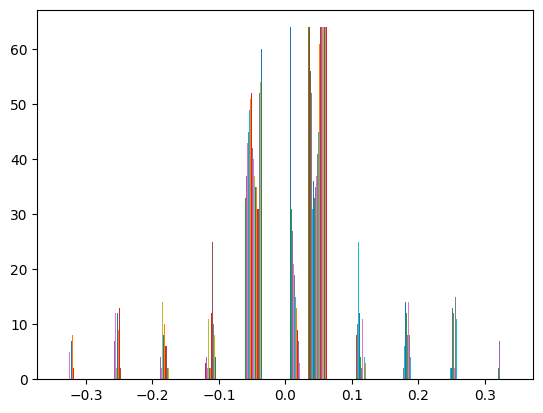

In [ ]:
plt.hist(true_train[1,:,:,0])

In [ ]:
from tensorflow.keras.layers import Input, Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
input_img = Input(shape=(64,64,3))
x = Conv2D(48, (7,7),activation='relu', padding='same')(input_img)
x = Conv2D(48, (7,7),activation='relu', padding='same')(x)
x = Conv2D(48, (7,7),activation='relu', padding='same')(x)
x = Conv2D(48, (7,7),activation='relu', padding='same')(x)
x = Conv2D(48, (7,7),activation='relu', padding='same')(x)
x = Conv2D(48, (7,7),activation='relu', padding='same')(x)
x = Conv2D(48, (7,7),activation='relu', padding='same')(x)
x_final = Conv2D(3, (7,7), padding='same')(x)
model = Model(input_img, x_final)
model.compile(optimizer='adam', loss='mse')


from keras.callbacks import ModelCheckpoint,EarlyStopping
model_cb=ModelCheckpoint('./Model_NOAA.hdf5', monitor='val_loss',save_best_only=True,verbose=1)
early_cb=EarlyStopping(monitor='val_loss', patience=100,verbose=1)
cb = [model_cb, early_cb]
history = model.fit(vor_train,true_train,epochs=5000,batch_size=32,verbose=1,callbacks=cb,shuffle=True,validation_data=[vor_test, true_test])

Epoch 1/5000
149/150 [============================>.] - ETA: 0s - loss: 0.6817
Epoch 1: val_loss improved from inf to 0.00624, saving model to ./Model_NOAA.hdf5
150/150 [==============================] - 17s 44ms/step - loss: 0.6772 - val_loss: 0.0062
Epoch 2/5000
  3/150 [..............................] - ETA: 5s - loss: 0.0056

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


149/150 [============================>.] - ETA: 0s - loss: 0.0049
Epoch 2: val_loss improved from 0.00624 to 0.00590, saving model to ./Model_NOAA.hdf5
150/150 [==============================] - 6s 38ms/step - loss: 0.0050 - val_loss: 0.0059
Epoch 3/5000
149/150 [============================>.] - ETA: 0s - loss: 0.0046
Epoch 3: val_loss improved from 0.00590 to 0.00556, saving model to ./Model_NOAA.hdf5
150/150 [==============================] - 6s 38ms/step - loss: 0.0046 - val_loss: 0.0056
Epoch 4/5000
149/150 [============================>.] - ETA: 0s - loss: 0.0044
Epoch 4: val_loss improved from 0.00556 to 0.00431, saving model to ./Model_NOAA.hdf5
150/150 [==============================] - 6s 39ms/step - loss: 0.0044 - val_loss: 0.0043
Epoch 5/5000
149/150 [============================>.] - ETA: 0s - loss: 0.0029
Epoch 5: val_loss improved from 0.00431 to 0.00268, saving model to ./Model_NOAA.hdf5
150/150 [==============================] - 6s 38ms/step - loss: 0.0029 - val_loss: 

In [ ]:
model = tf.keras.models.load_model('/content/Model_NOAA.hdf5')

In [ ]:
# Calculate inference time
start_time = time.time()
res_orign = model.predict(vor_test)
inference_time = time.time() - start_time
y_true = true_test
# Calculate SSIM

ssim_score = ssim(y_true, res_orign, multichannel=True)
res_orig_flat = res_orign.flatten()
y_true_flat = y_true.flatten()

mse_orig = mean_squared_error(res_orig_flat, y_true_flat)
rrmse = np.sqrt(mse_orig) / np.mean(y_true)




print("SSIM:", ssim_score)
print("RRMSE:", rrmse)
print("MSE_orig:", mse_orig)
print("Inference Time:", inference_time)

In [ ]:
n = 10
vor_train_dataset = np.array([vor_train[i:i+n,:,:,:] for i in range(len(vor_train)-n)]).astype('float16')
true_train_dataset = np.array([true_train[j:j+n,:,:,:] for j in range(len(true_train)-n)]).astype('float16')
vor_test_dataset = np.array([vor_test[i:i+n,:,:,:] for i in range(len(vor_test)-n)]).astype('float16')
true_test_dataset = np.array([true_test[j:j+n,:,:,:] for j in range(len(true_test)-n)]).astype('float16')


def create_shifted_frames(vor_data, true_data, n_frames):
    x = vor_data[0 : vor_data.shape[0] - n_frames]
    y = true_data[n_frames : true_data.shape[0]]
    return x, y

# Apply the processing function to the datasets.
x_train, y_train = create_shifted_frames(vor_train_dataset,true_train_dataset,n)
x_val, y_val = create_shifted_frames(vor_test_dataset,true_test_dataset,n)

print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

Training Dataset Shapes: (4780, 10, 64, 64, 3), (4780, 10, 64, 64, 3)
Validation Dataset Shapes: (2380, 10, 64, 64, 3), (2380, 10, 64, 64, 3)


In [ ]:
np.save('/content/x_train.npy',x_train)
np.save('/content/y_train.npy',y_train)
np.save('/content/x_val.npy',x_val)
np.save('/content/y_val.npy',y_val)

In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = '0'  # Errors ONLY
physical_devices = tf.config.list_physical_devices('GPU')
physical_devices[0]

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

## Pytorch COnvLSTM

In [ ]:
x_train = np.load('/content/x_train.npy', mmap_mode="r")
y_train = np.load('/content/y_train.npy', mmap_mode="r")
x_val= np.load('/content/x_val.npy', mmap_mode="r")
y_val = np.load('/content/y_val.npy', mmap_mode="r")

In [ ]:

def pde_loss6(y_true, y_pred):
    y_true = y_true.numpy()
    y_pred = y_pred.numpy()
    N = 64
    R = 64
    num_time_steps = 10
    batch_size = y_true.shape[0]

    SW = shallow(N=N, px=32, py=32, R=R, Hp=0.1, b=0.2)

    final_loss = []

    for i in range(num_time_steps - 1):
        loss = []
        for j in range(batch_size):
            # Extract image components
            image_u = y_pred[j, i, :, :, 0]
            image_v = y_pred[j, i, :, :, 1]
            image_h = y_pred[j, i, :, :, 2]

            SW.u, SW.v, SW.h = image_u, image_v, image_h

            true_u_vect = np.zeros((1, N, N))
            true_v_vect = np.zeros((1, N, N))
            true_h_vect = np.zeros((1, N, N))


            for k in range(6):
                SW.evolve()

                if k % 6 == 0:
                    true_u_vect[0] = SW.u

                    true_v_vect[0] = SW.v
                    true_h_vect[0] = SW.h

            # Concatenate the arrays along the last axis
            res = np.stack((true_u_vect[0], true_v_vect[0], true_h_vect[0]), axis=-1)

            res = tf.convert_to_tensor(res, dtype=tf.float32)
            mse_loss = tf.losses.mean_squared_error(res, y_true[j, i+1])

            loss.append(mse_loss)

        batch_loss = tf.reduce_mean(loss)
        final_loss.append(batch_loss)

    lossf = tf.reduce_mean(final_loss)
    return lossf





In [ ]:

def calculate_image_energy(img):
    dx = 1
    g = 9.81

    # Calculate kinetic energy
    kinetic_energy = 0.5 * tf.reduce_sum(tf.square(img[..., 0])) * dx**2
    kinetic_energy += 0.5 * tf.reduce_sum(tf.square(img[..., 1])) * dx**2

    # Calculate potential energy
    potential_energy = 0.5 * g * tf.reduce_sum(tf.square(img[..., 2])) * dx**2

    # Calculate total energy
    total_energy = kinetic_energy + potential_energy

    return total_energy

def calculate_energy_loss(y_true, y_pred):
    dx = 1
    g = 9.81

    batch_size = tf.shape(y_true)[0]
    num_steps = tf.shape(y_true)[1]
      # Calculate the energy of the last true image
    energy_diffs = []
    for i in range(10):
        predicted_energy = calculate_image_energy(y_pred[:, i])
        ideal_energy = calculate_image_energy(y_true[:, i])  # Calculate the energy of each predicted image
        energy_diff = tf.abs((predicted_energy - ideal_energy) / ideal_energy)  # Calculate the absolute difference between predicted and ideal energy
        energy_diffs.append(energy_diff)

    energy_restriction = tf.reduce_sum(energy_diffs)  / (tf.cast(batch_size, tf.float32) * tf.cast(num_steps, tf.float32)) # Sum the energy differences
    return energy_restriction  # Stack energy differences along the time dimension




def inverse_problem_regularization_loss(observed_data, model_output):
    lambda_reg=0.15
    mse_loss = tf.losses.mean_squared_error(observed_data, model_output)
    regularization_loss = tf.losses.mean_squared_error(model_output, observed_data)
    return mse_loss + lambda_reg * regularization_loss

def calculate_symmetry_loss(y_true, y_pred):
    batch_size = tf.shape(y_pred)[0]
    num_steps = tf.shape(y_pred)[1]
    image_size = tf.shape(y_pred)[2]

    u_left = y_pred[:, :, :, :image_size // 2, 1]
    u_right = y_pred[:, :, :, image_size // 2:, 1]
    u_lr_symmetry_diff = tf.abs(u_left - u_right)
    u_lr_symmetry_loss = tf.reduce_mean(u_lr_symmetry_diff)

    v_left = y_pred[:, :, :image_size // 2, :, 0]
    v_right = y_pred[:, :, image_size // 2:, :, 0]
    v_lr_symmetry_diff = tf.abs(v_left - v_right)
    v_lr_symmetry_loss = tf.reduce_mean(v_lr_symmetry_diff)

    h_left = y_pred[:, :, :image_size // 2, :, 2]
    h_right = y_pred[:, :, image_size // 2:, :, 2]
    h_lr_symmetry_diff = tf.abs(h_left - h_right)
    h_lr_symmetry_loss = tf.reduce_mean(h_lr_symmetry_diff)

    total_symmetry_loss = u_lr_symmetry_loss + v_lr_symmetry_loss #+ h_lr_symmetry_loss
    normalized_symmetry_loss = total_symmetry_loss / tf.cast(batch_size * num_steps, tf.float32)

    return normalized_symmetry_loss

def custom_loss(y_true, y_pred):
    energy_restriction = calculate_energy_loss(y_true, y_pred)
    inverse_loss = inverse_problem_regularization_loss(y_true, y_pred)
    pde = pde_loss6(y_true,y_pred)

    original_loss = tf.losses.mean_squared_error(y_true, y_pred)  # Original loss function (MSE)

    lambda_energy = 0.005
    lambda_inverse = 0.2
    lambda_symmetry = 0.3  # Adjust this weight based on your requirements

    loss = (
        original_loss +
        lambda_energy * energy_restriction +
        lambda_inverse * inverse_loss
        +lambda_symmetry * pde
    )

    return loss




# ConvLSTM

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

inp = layers.Input(shape=(n,64,64,3))

x = layers.ConvLSTM2D(
    filters=32,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)

x = layers.ConvLSTM2D(
    filters=32,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)

x = layers.ConvLSTM2D(
    filters=32,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)

x = layers.Conv3D(
    filters=3, kernel_size=(3, 3, 3), activation="relu", padding="same"
)(x)
#tf.config.run_functions_eagerly(True)
#tf.keras.backend.clear_session()
model = keras.models.Model(inp, x)


model.compile(loss=keras.losses.mean_squared_error, optimizer=keras.optimizers.Adam())


In [ ]:
tf.keras.backend.clear_session()


In [ ]:
model.fit(
    x_train,
    y_train,  # Pass y_train twice to match the output structure of custom_loss
    validation_data=(x_val, y_val),  # Pass y_val twice for validation data
    epochs=10,
    batch_size=16,
    shuffle=True
)

Epoch 1/10
299/299 [==============================] - 89s 238ms/step - loss: 0.0110 - val_loss: 0.0012
Epoch 2/10
299/299 [==============================] - 64s 215ms/step - loss: 6.8093e-04 - val_loss: 6.1232e-04
Epoch 3/10
299/299 [==============================] - 64s 215ms/step - loss: 5.5300e-04 - val_loss: 5.7518e-04
Epoch 4/10
299/299 [==============================] - 65s 217ms/step - loss: 5.2763e-04 - val_loss: 5.5344e-04
Epoch 5/10
299/299 [==============================] - 67s 223ms/step - loss: 5.1549e-04 - val_loss: 5.3486e-04
Epoch 6/10
299/299 [==============================] - 64s 216ms/step - loss: 5.0555e-04 - val_loss: 5.3709e-04
Epoch 7/10
299/299 [==============================] - 65s 218ms/step - loss: 4.9772e-04 - val_loss: 5.1884e-04
Epoch 8/10
299/299 [==============================] - 65s 216ms/step - loss: 4.9197e-04 - val_loss: 5.4462e-04
Epoch 9/10
299/299 [==============================] - 65s 217ms/step - loss: 4.8337e-04 - val_loss: 5.1062e-04
Epoch 10/

In [ ]:
model.save('./10stepspdeconvlstm.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
#model = tf.keras.models.load_model('/home/scheng1/Hanyang/Phy_Res/phy_model_0622.h5')
loaded_model = tf.keras.models.load_model('/home/scheng1/Hanyang/Phy_Res/Phy_model_10stepspdeconvlstm.h5',
                                           custom_objects={'custom_loss': custom_loss,
                                                           'inverse_problem_regularization_loss':inverse_problem_regularization_loss,
                                                            'calculate_energy_loss': calculate_energy_loss,
                                                            'pde_loss':pde_loss6})



In [ ]:
tf.config.run_functions_eagerly(True)
res_phy =tf.keras.models.load_model('/home/scheng1/Hanyang/Phy_Res/Phy_model_10stepspdeconvlstm.h5',
                                           custom_objects={'custom_loss': custom_loss,
                                                           'inverse_problem_regularization_loss':inverse_problem_regularization_loss,
                                                            'calculate_energy_loss': calculate_energy_loss,
                                                            'pde_loss6':pde_loss6})

In [ ]:
x_train = np.load('/home/scheng1/Hanyang/Datasets/x_train.npy', mmap_mode="r")
y_train = np.load('/home/scheng1/Hanyang/Datasets/y_train.npy', mmap_mode="r")
x_val= np.load('/home/scheng1/Hanyang/Datasets/x_val.npy', mmap_mode="r")
y_val = np.load('/home/scheng1/Hanyang/Datasets/y_val.npy', mmap_mode="r")

In [ ]:
from tensorflow.python.keras.models import load_model
# Save the trained model
model.save('/home/scheng1/Hanyang/Phy_Res/Phy_model_10stepspdeconvlstm.h5')



2023-08-22 15:42:51.092271: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-08-22 15:42:51.108978: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3504000000 Hz
2023-08-22 15:42:51.434300: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2023-08-22 15:42:52.330985: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8100
2023-08-22 15:42:53.006442: E tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-08-22 15:42:53.006462: W tensorflow/stream_executor/gpu/asm_compiler.cc:56] Couldn't invoke ptxas --version
2023-08-22 15:42:53.006974: E tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-08-22 15:42:53.007130: W tensorflow/stream_executor/gpu/redzone_allocator.cc:31

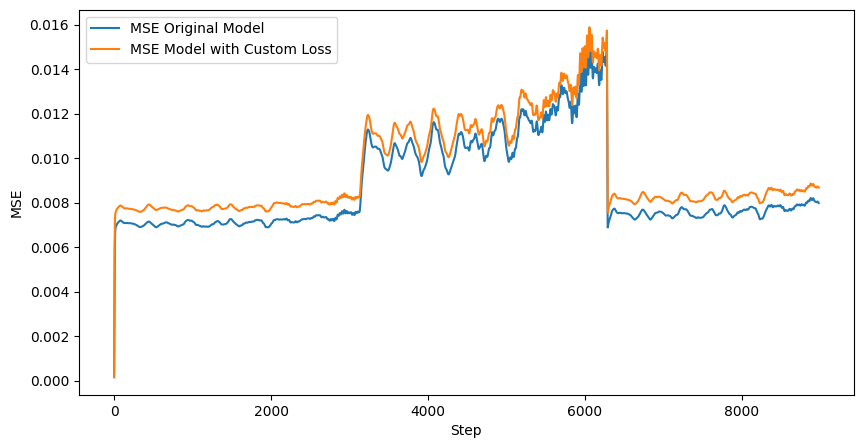

In [ ]:
orig_model = tf.keras.models.load_model('/home/scheng1/Hanyang/Phy_Res/orign_model_10steps.h5')
res_orig =tf.keras.models.load_model('/home/scheng1/Hanyang/Phy_Res/Phy_model_10stepspdeconvlstm.h5',
                                           custom_objects={'custom_loss': custom_loss,
                                                           'inverse_problem_regularization_loss':inverse_problem_regularization_loss,
                                                            'calculate_energy_loss': calculate_energy_loss,
                                                            'pde_loss6':pde_loss6})

# Define a function to make predictions using the model and calculate MSE

# Define a function to make step-by-step predictions using the model and calculate MSE
def predict_and_calc_mse(model, x_data, y_data):
    mse_values = []
    num_steps = x_data.shape[0]

    # Initial input for the first step
    x_input = x_data[0, :, :, :, :]

    for step in range(num_steps):
        x_input = np.expand_dims(x_input, axis=0)  # Add a batch dimension
        y_true = np.expand_dims(y_data[step, :, :, :, :], axis=0)  # Add a batch dimension

        # Predict the output for the current step
        y_pred = model.predict(x_input)

        mse = np.mean((y_pred - y_true) ** 2)
        mse_values.append(mse)

        # Prepare input for the next step
        x_input = y_pred[0]

    return mse_values


# Call the function for the 'orig_model' and 'res_orig' model
mse_orig_model = predict_and_calc_mse(orig_model, x_val, y_val)
mse_res_orig = predict_and_calc_mse(res_orig, x_val, y_val)

# Plot the MSE values
plt.figure(figsize=(10, 5))
plt.plot(mse_orig_model, label='MSE Original Model')
plt.plot(mse_res_orig, label='MSE Model with Custom Loss')
plt.xlabel('Step')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error


#orig_model = tf.keras.models.load_model('/home/scheng1/Hanyang/Phy_Res/orign_model_10steps.h5')
#res_orig =tf.keras.models.load_model('/home/scheng1/Hanyang/Phy_Res/Phy_model_10stepsfinal.h5',
                                          # custom_objects={'custom_loss': custom_loss,
                                                    #       'inverse_problem_regularization_loss':inverse_problem_regularization_loss,
                                                      #      'calculate_energy_loss': calculate_energy_loss,
                                                       #     'calculate_symmetry_loss':calculate_symmetry_loss})

# Calculate inference time
start_time = time.time()
res_orign = model.predict(x_val)
inference_time = time.time() - start_time

# Assuming vor_test is your concatenated array with shape (n, 64, 64, 3)
# And vor_test_u_scaler, vor_test_v_scaler, vor_test_h_scaler are the scalers used for u, v, and h channels respectively

# Step 1: Separate the channels
vor_test_u = res_orign[:,0,:,:,0]
vor_test_v = res_orign[:,0,:,:,1]
vor_test_h = res_orign[:,0,:,:,2]

# Step 2: Inverse transform each channel
vor_test_u_original = vor_test_u * range_vu + min_vu
vor_test_v_original = vor_test_v * range_vv + min_vv
vor_test_h_original = vor_test_h * range_vh + min_vh

# Step 3: Recombine the channels
res_orign = np.stack([vor_test_u_original, vor_test_v_original, vor_test_h_original], axis=-1)

# Repeat the same steps for y_val if needed
vor_test_u = y_val[:,0,:,:,0]
vor_test_v = y_val[:,0,:,:,1]
vor_test_h = y_val[:,0,:,:,2]

vor_test_u_original = vor_test_u * range_vu + min_vu
vor_test_v_original = vor_test_v * range_vv + min_vv
vor_test_h_original = vor_test_h * range_vh + min_vh

# Recombine the channels
y_val = np.stack([vor_test_u_original, vor_test_v_original, vor_test_h_original], axis=-1)


res_orign = res_orign[:,:,:,:]
y_true = y_val[:, :, :, :]
res_orig_flat = res_orign.flatten()
y_true_flat = y_true.flatten()

mse_orig = mean_squared_error(res_orig_flat, y_true_flat)

ssim_score = ssim(y_true, res_orign, multichannel=True)

# Calculate RRMSE
rrmse = np.sqrt(mse_orig) / np.mean(y_true)


print("SSIM:", ssim_score)
print("RRMSE:", rrmse)
print("MSE_orig:", mse_orig)
print("Inference Time:", inference_time)


75/75 [==============================] - 7s 90ms/step


<ipython-input-31-dbac277f2b5f>:52: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_score = ssim(y_true, res_orign, multichannel=True)
/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


SSIM: 0.8414425
RRMSE: 0.1023664
MSE_orig: 0.0012594232
Inference Time: 10.843816757202148


In [ ]:
y_val.shape

(2380, 10, 64, 3, 3)

In [ ]:
from sklearn.metrics import mean_squared_error
from tensorflow.python.keras.models import load_model
#orig_model = tf.keras.models.load_model('/home/scheng1/Hanyang/Phy_Res/orign_model_10steps.h5')
res_phy =tf.keras.models.load_model('/home/scheng1/Hanyang/Phy_Res/Phy_model_10stepspdeconvlstm.h5',
                                           custom_objects={'custom_loss': custom_loss,
                                                           'inverse_problem_regularization_loss':inverse_problem_regularization_loss,
                                                            'calculate_energy_loss': calculate_energy_loss,
                                                            'pde_loss6':pde_loss6})
res_orig=orig_model.predict(x_val)
res_phy=res_phy.predict(x_val)

res_orig = res_orig[:,0,:,:,:]
res_phy=res_phy[:,0,:,:,:]

y_true = y_val[:,0,:,:,:]

mse_orig = mean_squared_error(res_orig.flatten(), y_true.flatten())
mse_phy = mean_squared_error(res_phy.flatten(), y_true.flatten())

print("MSE_orig:", mse_orig)
print("mse_phy:", mse_phy)

MSE_orig: 0.0015882252
mse_phy: 0.0016327875


In [ ]:
from skimage.metrics import structural_similarity as ssim

# Compute SSIM between the two images

ssim_score_orig = ssim(y_true, res_orig,multichannel=True)
ssim_score_phy = ssim(y_true, res_phy,multichannel=True)

# Print the SSIM score
print("The SSIM score orig is:", ssim_score_orig)
print("The SSIM score phy is:", ssim_score_phy)


# Flatten the image sets to size (7500, 12288)
flat_set_true = y_true.reshape((y_true.shape[0], -1))
flat_set_orig = res_orig.reshape((res_orig.shape[0], -1))
flat_set_phy = res_phy.reshape((res_phy.shape[0], -1))

# Compute the L2 norm between the two flattened sets
diff_vectors_orig = flat_set_true - flat_set_orig
diff_vectors_phy = flat_set_true - flat_set_phy

l2_norms_orig = np.linalg.norm(diff_vectors_orig, axis=1)
l2_norms_phy = np.linalg.norm(diff_vectors_phy, axis=1)


relative_errors_orig = l2_norms_orig / np.linalg.norm(flat_set_true, axis=1)
relative_errors_phy = l2_norms_phy / np.linalg.norm(flat_set_true, axis=1)

mean_relative_error_orig = np.mean(relative_errors_orig)
mean_relative_error_phy = np.mean(relative_errors_phy)


# Print the L2 norm error
print("The L2 norm error orig is:", mean_relative_error_orig)
print("The L2 norm error phy is:", mean_relative_error_phy)

/home/scheng1/miniconda3/envs/a6000/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  """
/home/scheng1/miniconda3/envs/a6000/lib/python3.7/site-packages/skimage/_shared/utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)
/home/scheng1/miniconda3/envs/a6000/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  


The SSIM score orig is: 0.8190329
The SSIM score phy is: 0.8171802
The L2 norm error orig is: 0.07497508
The L2 norm error phy is: 0.07623915


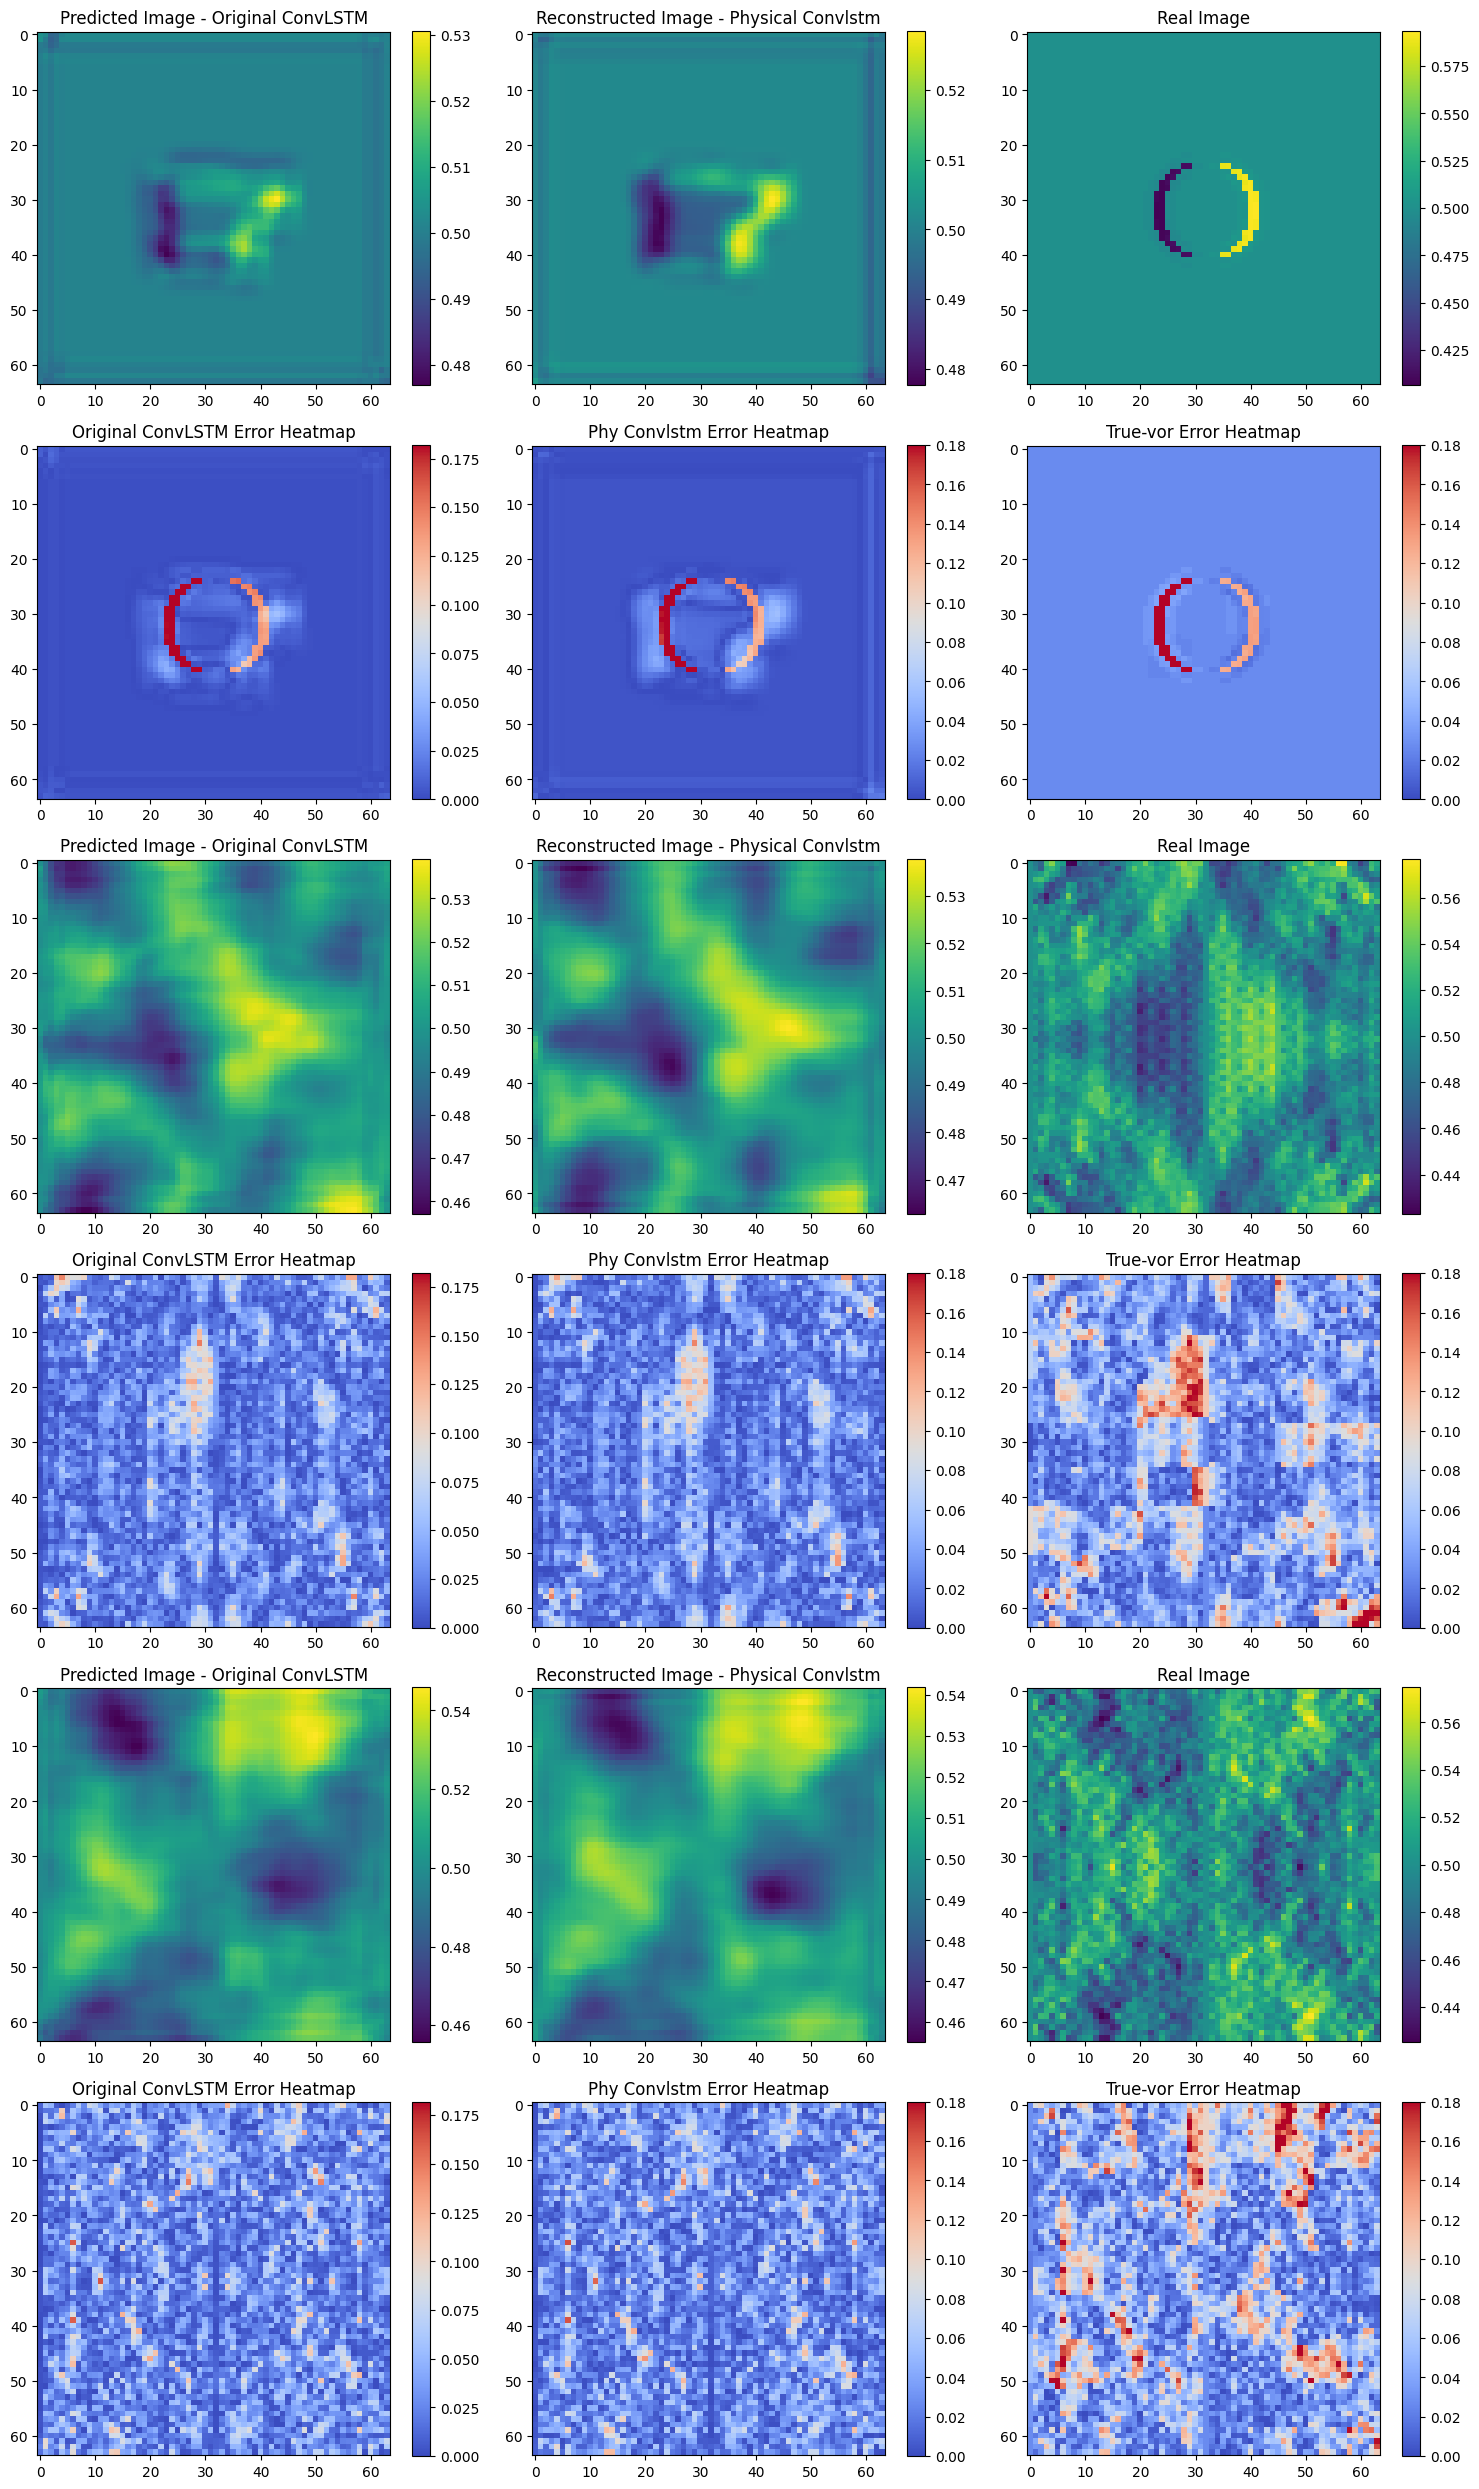

In [ ]:
x_train = np.load('/home/scheng1/Hanyang/Datasets/x_train.npy', mmap_mode="r")
y_train = np.load('/home/scheng1/Hanyang/Datasets/y_train.npy', mmap_mode="r")
x_val= np.load('/home/scheng1/Hanyang/Datasets/x_val.npy', mmap_mode="r")
y_val = np.load('/home/scheng1/Hanyang/Datasets/y_val.npy', mmap_mode="r")
# Define the subplot layout
fig, axs = plt.subplots(nrows=6, ncols=3, figsize=(15, 25))

# Define the vmin and vmax values for the heatmaps
vmin = 0
vmax = 0.18
res = res_orig[:,:,:,0]
reconstructed_images_train = res_phy[:,:,:,0]
y_val = y_val[:,0,:,:,0]
x_val = x_val[:,0,:,:,0]


# Loop through the subplots and show the images and heatmaps
for i in (0,2,4):
    # Show the predicted image
    im = axs[i, 0].imshow(res[400*i, :, :])
    axs[i, 0].set_title('Predicted Image - Original ConvLSTM')
    fig.colorbar(im, ax=axs[i, 0])
    # Show the reconstructed image
    im = axs[i, 1].imshow(reconstructed_images_train[400*i, :, :])
    axs[i, 1].set_title('Reconstructed Image - Physical Convlstm')
    fig.colorbar(im, ax=axs[i, 1])

    im = axs[i, 2].imshow(y_val[400*i, :, :])
    axs[i, 2].set_title('Real Image')
    fig.colorbar(im, ax=axs[i, 2])

    # Calculate the L2 norm error between the predicted and target images
    flat_target = y_val[400*i,:, :]
    flat_pred = res[400*i,:, :]
    diff_vector = flat_target - flat_pred
    l2_norm_error = diff_vector / flat_target

    # Show the heatmap with a colorbar
    abs_diff_vector = np.abs(l2_norm_error)
    im = axs[i+1, 0].imshow(abs_diff_vector, cmap='coolwarm', vmin=vmin, vmax=vmax+0.002)
    fig.colorbar(im, ax=axs[i+1, 0])
    axs[i+1, 0].set_title('Original ConvLSTM Error Heatmap')

    # Calculate the L2 norm error between the reconstructed and target images
    flat_target = y_val[400*i, :, :]
    flat_pred = reconstructed_images_train[400*i, :, :]
    diff_vector = flat_target - flat_pred
    l2_norm_error = diff_vector / flat_target

    # Show the heatmap with a colorbar
    abs_diff_vector = np.abs(l2_norm_error)
    im = axs[i+1, 1].imshow(abs_diff_vector, cmap='coolwarm', vmin=vmin, vmax=vmax)
    fig.colorbar(im, ax=axs[i+1, 1])
    axs[i+1, 1].set_title('Phy Convlstm Error Heatmap')

    # Calculate the L2 norm error between the reconstructed and target images
    flat_target = y_val[400*i, :, :]
    flat_pred = x_val[400*i, :, :]
    diff_vector = flat_target - flat_pred
    l2_norm_error = diff_vector / flat_target

    # Show the heatmap with a colorbar
    abs_diff_vector = np.abs(l2_norm_error)
    im = axs[i+1, 2].imshow(abs_diff_vector, cmap='coolwarm', vmin=vmin, vmax=vmax)
    fig.colorbar(im, ax=axs[i+1, 2])
    axs[i+1, 2].set_title('True-vor Error Heatmap')

# Adjust the subplot layout
fig.tight_layout()
plt.savefig('my_figure.png')

plt.show()

In [ ]:

# Load the saved model
#loaded_model = tf.keras.models.load_model('/home/scheng1/Hanyang/Datasets/my_model_4.h5')
#res = loaded_model.predict(x_val)
res=model.predict(x_val)


In [ ]:
res_d = res[:,0,:,:,:]
y_true = y_val[:,0,:,:,:]
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(res_d.flatten(), y_true.flatten())
print("MSE:", mse)



MSE: 0.0005541991


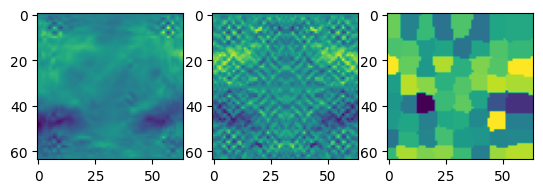

In [ ]:
plt.subplot(1,3,1)
imshow(res[3000,0,:,:,1])
plt.subplot(1,3,2)
imshow(y_val[3000,0,:,:,1])
plt.subplot(1,3,3)
imshow(x_val[2300,0,:,:,1])

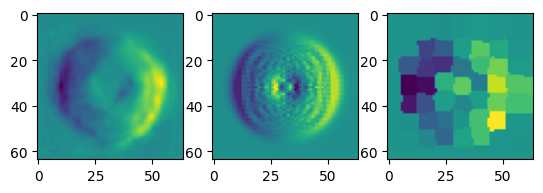

In [ ]:
plt.subplot(1,3,1)
imshow(res[200,0,:,:,0])
plt.subplot(1,3,2)
imshow(y_val[200,0,:,:,0])
plt.subplot(1,3,3)
imshow(x_val[201,0,:,:,0])

In [ ]:
res_ssim = res[:,0,:,:,:]
y_val_ssim = y_val[:,0,:,:,:]

In [ ]:
y_val_ssim.shape

(12992, 64, 64, 3)

In [ ]:
from skimage.metrics import structural_similarity as ssim

# Compute SSIM between the two images

ssim_score = ssim(y_val_ssim, res_ssim,multichannel=True)

# Print the SSIM score
print("The SSIM score is:", ssim_score)

# Flatten the image sets to size (7500, 12288)
flat_set1 = y_val_ssim.reshape((12992, -1))
flat_set2 = res_ssim.reshape((12992, -1))

# Compute the L2 norm between the two flattened sets
diff_vectors = flat_set1 - flat_set2
l2_norms = np.linalg.norm(diff_vectors, axis=1)
relative_errors = l2_norms / np.linalg.norm(flat_set1, axis=1)
mean_relative_error = np.mean(relative_errors)


# Print the L2 norm error
print("The L2 norm error is:", mean_relative_error)

/home/scheng1/miniconda3/envs/a6000tf26/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  """


The SSIM score is: 0.90589935
The L2 norm error is: 0.04547094


In [ ]:
relative_errors_3d = relative_errors.reshape(7484,64,64,3)
fig, ax = plt.subplots()
im = ax.imshow(relative_errors_3d, cmap='viridis')

# Set the axis labels and title
ax.set_xlabel('Image Set 2')
ax.set_ylabel('Image Set 1')
ax.set_title('L2 Norm Error Heatmap')

In [ ]:
del loaded_model

# ConvAutoencoder

In [11]:
vor_train = np.load('/content/0121/vor_train.npy', mmap_mode="r")
true_train = np.load('/content/0121/true_train.npy', mmap_mode="r")
vor_test = np.load('/content/0121/vor_test.npy', mmap_mode="r")
true_test = np.load('/content/0121/true_test.npy', mmap_mode="r")

In [12]:
vor_image = np.vstack([vor_train,vor_test])
true_image = np.vstack([true_train,true_test])


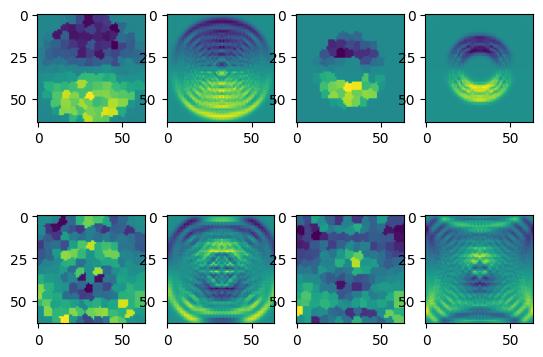

In [ ]:
plt.subplot(2,4,1)
plt.imshow(vor_test[100,:,:,0])
plt.subplot(2,4,2)
plt.imshow(true_test[100,:,:,0])
plt.subplot(2,4,3)
plt.imshow(vor_train[300,:,:,0])
plt.subplot(2,4,4)
plt.imshow(true_train[300,:,:,0])
plt.subplot(2,4,5)
plt.imshow(vor_test[500,:,:,0])
plt.subplot(2,4,6)
plt.imshow(true_test[500,:,:,0])
plt.subplot(2,4,7)
plt.imshow(vor_test[200,:,:,0])
plt.subplot(2,4,8)
plt.imshow(true_test[200,:,:,0])

In [13]:
import tensorflow as tf
from tensorflow.keras import layers, models

tf.keras.utils.set_random_seed(1)

# Encoder
input_img = layers.Input(shape=(64, 64, 3))
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.Flatten()(x)
encoded = layers.Dense(512, activation='relu', name='encoded')(x)

# Decoder
x = layers.Dense(16*16*64, activation='relu')(encoded)
x = layers.Reshape((16, 16, 64))(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(3, (3, 3), activation='tanh', padding='same', name='decoded')(x)

# Autoencoder Model
autoencoder = models.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 16)        4624      
                                                                 
 flatten (Flatten)           (None, 16384)             0         
                                                                 
 encoded (Dense)             (None, 512)               8389120   
                                                             

In [14]:

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Set the random seed for reproducibility
tf.keras.utils.set_random_seed(1337)

# Callbacks for adaptive learning rate and early stopping
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=20,
    min_lr=1e-6
)
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=30,
    restore_best_weights=True
)

# Training the autoencoder
# Make sure autoencoder, vor_train, true_train, vor_test, and true_test are properly defined
history = autoencoder.fit(
    vor_train,
    true_train,
    epochs=100,
    batch_size=256,
    callbacks=[reduce_lr, early_stop],
    validation_data=(vor_test, true_test),
    shuffle=True
)


Epoch 1/100
159/159 [==============================] - 12s 37ms/step - loss: 0.0135 - val_loss: 0.0045 - lr: 0.0010
Epoch 2/100
159/159 [==============================] - 4s 24ms/step - loss: 0.0042 - val_loss: 0.0039 - lr: 0.0010
Epoch 3/100
159/159 [==============================] - 4s 24ms/step - loss: 0.0039 - val_loss: 0.0037 - lr: 0.0010
Epoch 4/100
159/159 [==============================] - 4s 24ms/step - loss: 0.0038 - val_loss: 0.0037 - lr: 0.0010
Epoch 5/100
159/159 [==============================] - 4s 24ms/step - loss: 0.0037 - val_loss: 0.0036 - lr: 0.0010
Epoch 6/100
159/159 [==============================] - 4s 24ms/step - loss: 0.0037 - val_loss: 0.0036 - lr: 0.0010
Epoch 7/100
159/159 [==============================] - 4s 24ms/step - loss: 0.0037 - val_loss: 0.0036 - lr: 0.0010
Epoch 8/100
159/159 [==============================] - 4s 24ms/step - loss: 0.0036 - val_loss: 0.0035 - lr: 0.0010
Epoch 9/100
159/159 [==============================] - 4s 24ms/step - loss: 0.0

In [15]:
import json
from tensorflow.keras.models import model_from_json

# Step 1: Serialize model to JSON
model_json = autoencoder.to_json()
with open("./0121/autoencoder_architecture.json", "w") as json_file:
    json_file.write(model_json)

# Step 2: Serialize weights to HDF5
autoencoder.save_weights("./0121/autoencoder_weights.h5")
print("Saved model to disk 😄")

# Step 3 & 4: Document training parameters and performance metrics
with open("./0121/model_info.txt", "w") as f:
    f.write("Training Parameters and Performance Metrics\n")
    f.write("=================================================\n")
    f.write("ReduceLROnPlateau settings:\n")
    f.write(f"- Monitor: val_loss\n")
    f.write(f"- Factor: 0.2\n")
    f.write(f"- Patience: 30\n")
    f.write(f"- Min LR: 1e-6\n\n")
    f.write("EarlyStopping settings:\n")
    f.write(f"- Monitor: val_loss\n")
    f.write(f"- Patience: 40\n")
    f.write(f"- Restore Best Weights: True\n\n")
    f.write("Training History:\n")
    for key, values in history.history.items():
        f.write(f"- {key}: {values}\n")

print("All model information has been saved successfully 😄")

# To reload the model architecture and weights later:
# with open('autoencoder_architecture.json', 'r') as json_file:
#     loaded_model_json = json_file.read()
# loaded_model = model_from_json(loaded_model_json)
# loaded_model.load_weights("autoencoder_weights.h5")


Saved model to disk 😄
All model information has been saved successfully 😄


In [ ]:
with open('./0121/autoencoder_architecture.json', 'r') as json_file:
     loaded_model_json = json_file.read()
     loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("./0121/autoencoder_weights.h5")

In [ ]:
last_layers = loaded_model.layers[-8:]
new_model = tf.keras.models.Sequential(last_layers)

NameError: name 'loaded_model' is not defined

In [ ]:
last_layers

In [16]:
from tensorflow import keras
encoder = tf.keras.models.Model(input_img, encoded)

encoded_features = encoder.predict(vor_image)
reconstructed_images = autoencoder.predict(vor_image)



1407/1407 [==============================] - 3s 2ms/step


In [17]:

last_layers = autoencoder.layers[-7:]
new_model = keras.models.Sequential(last_layers)

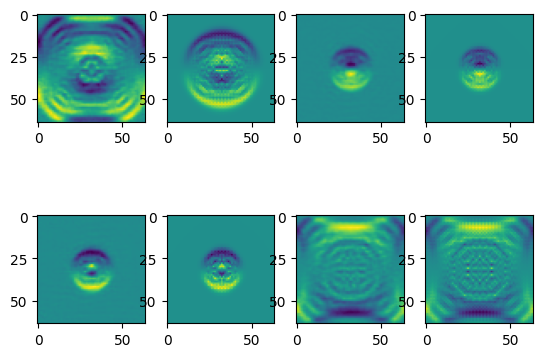

In [18]:

plt.subplot(2,4,1)
plt.imshow(reconstructed_images[200,:,:,0])
plt.subplot(2,4,2)
plt.imshow(true_image[-200,:,:,0])
plt.subplot(2,4,3)
plt.imshow(reconstructed_images[-300,:,:,0])
plt.subplot(2,4,4)
plt.imshow(true_image[-300,:,:,0])
plt.subplot(2,4,5)
plt.imshow(reconstructed_images[-580,:,:,0])
plt.subplot(2,4,6)
plt.imshow(true_image[-580,:,:,0])
plt.subplot(2,4,7)
plt.imshow(reconstructed_images[-30,:,:,0])
plt.subplot(2,4,8)
plt.imshow(true_image[-30,:,:,0])

In [ ]:
reconstructed_images.shape

(3600, 64, 64, 3)

In [ ]:
from skimage.metrics import structural_similarity as ssim

# Compute SSIM between the two images
ssim_score = ssim(true_image[-4500:], reconstructed_images[-4500:],multichannel=True)

# Print the SSIM score
print("The SSIM score is:", ssim_score)

# Flatten the image sets to size (7500, 12288)
flat_set1 = true_image.reshape((2400, -1))
flat_set2 = reconstructed_images.reshape((2400, -1))

# Compute the L2 norm between the two flattened sets
diff_vectors = flat_set1 - flat_set2
l2_norms = np.linalg.norm(diff_vectors, axis=1)
relative_errors = l2_norms / np.linalg.norm(flat_set1, axis=1)
mean_relative_error = np.mean(relative_errors)


# Print the L2 norm error
print("The L2 norm error is:", mean_relative_error)

<ipython-input-20-8a9982e3827f>:4: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_score = ssim(true_image[-4500:], reconstructed_images[-4500:],multichannel=True)
/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


The SSIM score is: 0.8816793823287589
The L2 norm error is: 0.07774160816279124


In [96]:
#encoded = norm_auto(encoded_features)

import numpy as np
from sklearn.model_selection import train_test_split

# Assuming encoded_features is defined and loaded correctly
n = 10
x_train_cnn, x_test_cnn = train_test_split(encoded_features, test_size=1/10, shuffle=False)

def create_sequences(data, sequence_length):
    return np.array([data[i:i+sequence_length] for i in range(len(data) - sequence_length)])

def create_shifted_frames(data, n_frames):
    return data[:-n_frames], data[n_frames:]

# Create sequences
x_train = create_sequences(x_train_cnn, n)
x_test = create_sequences(x_test_cnn, n)

# Apply the processing function to the datasets
x_train, y_train = create_shifted_frames(x_train, n)
x_val, y_val = create_shifted_frames(x_test, n)

print(y_train.shape)  # To display the shape of y_train

(40480, 10, 512)


In [20]:
import tensorflow as tf

class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, decoder_model, **kwargs):
        super(DecoderLayer, self).__init__(**kwargs)
        # Ensure the decoder_model is a callable (e.g., a Keras model or a function)
        if not callable(decoder_model):
            raise ValueError("decoder_model must be callable")
        self.decoder_model = decoder_model

    def call(self, inputs):
        # It's good practice to check if the inputs are valid for the decoder_model
        # This can be more specific based on the expected input shape, type, etc.
        if inputs is None:
            raise ValueError("Input to DecoderLayer cannot be None")

        # Use decoder_model to decode the inputs
        decoded_images = self.decoder_model(inputs)
        return decoded_images



In [ ]:
DecoderLayer

__main__.DecoderLayer

### 0721 new loss by gpt

In [21]:
x=512
n=10
def calculate_energy_loss(y_true, y_pred):
    decoder_layer = DecoderLayer(new_model)  # Create a custom decoder layer object, passing in decoder_model
    y_pred = tf.reshape(y_pred, (-1, x))
    y_true = tf.reshape(y_true, (-1, x))
    y_pred = decoder_layer(y_pred)
    y_pred = tf.reshape(y_pred, (-1, n, 64, 64, 3))
    y_true = decoder_layer(y_true)
    y_true = tf.reshape(y_true, (-1, n, 64, 64, 3))
    batch_size = tf.shape(y_true)[0]
    num_steps = tf.shape(y_true)[1]
      # Calculate the energy of the last true image
    energy_diffs = []
    for i in range(n):
        predicted_energy = calculate_image_energy(y_pred[:, i])
        ideal_energy = calculate_image_energy(y_true[:, i])  # Calculate the energy of each predicted image
        energy_diff = tf.abs((predicted_energy - ideal_energy) / ideal_energy)  # Calculate the absolute difference between predicted and ideal energy
        energy_diffs.append(energy_diff)

    energy_restriction = tf.reduce_sum(energy_diffs)  / (tf.cast(batch_size, tf.float32) * tf.cast(num_steps, tf.float32)) # Sum the energy differences
    return energy_restriction  # Stack energy differences along the time dimension

def calculate_energy_loss(y_true, y_pred):
    decoder_layer = DecoderLayer(new_model)  # Use the custom decoder layer
    y_pred = tf.reshape(y_pred, (-1, x))
    y_true = tf.reshape(y_true, (-1, x))

    y_pred_decoded = decoder_layer(y_pred)
    y_true_decoded = decoder_layer(y_true)

    y_pred_decoded = tf.reshape(y_pred_decoded, (-1, 64, 64, 3))
    y_true_decoded = tf.reshape(y_true_decoded, (-1, 64, 64, 3))

    predicted_energy = calculate_image_energy(y_pred_decoded)
    ideal_energy = calculate_image_energy(y_true_decoded)

    energy_diff = tf.abs(predicted_energy - ideal_energy)
    energy_restriction = tf.reduce_mean(energy_diff)  # Use mean to normalize over batch and steps

    return energy_restriction

def roll(A, shift, axis):
    return tf.roll(A, shift, axis=axis)

def dxy(A, dx, axis):
    return (roll(A, -1, axis) - roll(A, 1, axis)) / (2. * dx)

def d_dt(h, u, v, dx):
    du_dt = -dxy(h, dx, 2) - 0.2 * u
    dv_dt = -dxy(h, dx, 1) - 0.2 * v
    H = 0
    dh_dt = -dxy(u * (H + h), dx, 2) - dxy(v * (H + h), dx, 1)
    return dh_dt, du_dt, dv_dt

def evolve(h, u, v, dt=0.0001, dx=0.01):
    dh_dt, du_dt, dv_dt = d_dt(h, u, v, dx)
    h += dh_dt * dt
    u += du_dt * dt
    v += dv_dt * dt
    return h, u, v

def compute_evolve_loss(y_true, y_pred):
    # Decode and reshape
    decoder_layer = DecoderLayer(new_model)
    y_pred = decoder_layer(tf.reshape(y_pred, (-1, x)))
    y_pred = tf.reshape(y_pred, (-1, n, 64, 64, 3))

    y_true = decoder_layer(tf.reshape(y_true, (-1, x)))
    y_true = tf.reshape(y_true, (-1, n, 64, 64, 3))

    batch_size = tf.shape(y_true)[0]
    PDE_losses = []

    for i in range(batch_size):
        for j in range(10 - 1):
            h_pred, u_pred, v_pred = y_pred[i, j, ..., 2], y_pred[i, j, ..., 0], y_pred[i, j, ..., 1]
            h_pred, u_pred, v_pred = evolve(h_pred, u_pred, v_pred, dx=0.01)

            # Recombine the evolved images
            evolved_pred = tf.stack([u_pred, v_pred, h_pred], axis=-1)

            loss = tf.square(evolved_pred - y_true[i, j+1])
            PDE_losses.append(loss)

    stacked_losses = tf.stack(PDE_losses)
    return tf.reduce_mean(stacked_losses)

import tensorflow as tf

def compute_evolve_loss(y_true, y_pred, new_model):
    # Assuming evolve function is defined elsewhere and compatible with TensorFlow operations

    def decode_and_reshape(y, decoder_layer):
        decoded = decoder_layer(tf.reshape(y, (-1, 128)))
        return tf.reshape(decoded, (-1, 10, 64, 64, 3))

    # Instantiate the decoder layer
    decoder_layer = DecoderLayer(new_model)

    # Decode and reshape predictions and true values
    y_pred = decode_and_reshape(y_pred, decoder_layer)
    y_true = decode_and_reshape(y_true, decoder_layer)

    # Calculate PDE loss for each example in the batch
    PDE_losses = []
    for i in range(tf.shape(y_true)[0]):
        for j in range(9):  # loop until the second last element
            h_pred, u_pred, v_pred = y_pred[i, j, ..., 2], y_pred[i, j, ..., 0], y_pred[i, j, ..., 1]
            h_pred, u_pred, v_pred = evolve(h_pred, u_pred, v_pred, dx=0.01)

            # Recombine the evolved images
            evolved_pred = tf.stack([u_pred, v_pred, h_pred], axis=-1)

            # Compute squared error
            loss = tf.reduce_mean(tf.square(evolved_pred - y_true[i, j+1]), axis=[1, 2, 3])
            PDE_losses.append(loss)

    # Calculate the average loss across all examples and time steps
    return tf.reduce_mean(tf.stack(PDE_losses))



In [98]:
x= 512
n=10
batch=128
'''def energy_conservation_constraint(y_true, y_pred):

    decoder_layer = DecoderLayer(new_model)  # Create a custom decoder layer object, passing in decoder_model
    y_pred = tf.reshape(y_pred, (-1, x))
    y_true = tf.reshape(y_true, (-1, x))
    y_pred = decoder_layer(y_pred)
    y_pred = tf.reshape(y_pred, (-1, n, 64, 64, 3))
    y_true = decoder_layer(y_true)
    y_true = tf.reshape(y_true, (-1, n, 64, 64, 3))
    energy_sequence_true = [calculate_image_energy(y_true[:, t]) for t in range(y_true.shape[1])]
    energy_sequence_pred = [calculate_image_energy(y_pred[:, t]) for t in range(y_pred.shape[1])]

    # Energy difference over the sequence
    energy_diff_true = tf.abs(energy_sequence_true[-1] - energy_sequence_true[0])
    energy_diff_pred = tf.abs(energy_sequence_pred[-1] - energy_sequence_pred[0])

    # Penalize the predicted sequence if the energy difference doesn't match the true difference
    energy_error = tf.abs(energy_diff_true - energy_diff_pred)
    return energy_error'''


def calculate_image_energy(img):
    dx = 1
    g = 9.81

    img = tf.reshape(img, (-1, img.shape[2], img.shape[3],3))

    kinetic_energy = 0.5 * tf.reduce_sum(tf.square(img[..., 0]), axis=(1, 2)) * dx**2
    kinetic_energy += 0.5 * tf.reduce_sum(tf.square(img[..., 1]), axis=(1, 2)) * dx**2
    # Calculate potential energy
    potential_energy = 0.5 * g * tf.reduce_sum(tf.square(img[..., 2]), axis=(1, 2)) * dx**2
    # Calculate total energy
    total_energy = kinetic_energy + potential_energy
    return total_energy

def calculate_relative_energy_error(y_true, y_pred):

    decoder_layer = DecoderLayer(new_model)  # Create a custom decoder layer object, passing in decoder_model
    y_pred = tf.reshape(y_pred, (-1, x))
    y_true = tf.reshape(y_true, (-1, x))
    y_pred = decoder_layer(y_pred)
    batch = y_true.shape[0]
    y_pred = tf.reshape(y_pred, (-1,n, 64, 64, 3))
    y_true = decoder_layer(y_true)

    y_true = tf.reshape(y_true, (-1,n, 64, 64, 3))
    energy_true = calculate_image_energy(y_true)
    energy_pred = calculate_image_energy(y_pred)
    sub = energy_pred-energy_true

    abs_sub = tf.abs(sub)

    diff = tf.reduce_sum(abs_sub)#/(batch*n)
    return diff



def custom_loss(y_true, y_pred):
    mse_loss = tf.losses.mean_squared_error(y_true, y_pred)
    energy_restriction = calculate_relative_energy_error(y_true, y_pred)
    #energy_conservation_penalty = energy_conservation_constraint(y_true, y_pred)
    #pde_loss = compute_evolve_loss(y_true, y_pred)
    loss = mse_loss + 0.00000001*energy_restriction# + 0.00008*energy_conservation_penalty#+0.05*pde_loss#+0.1*calculate_relative_energy_error
    return loss

In [99]:
import tensorflow as tf
from tensorflow.keras import models, layers, callbacks

# Assuming custom_loss, calculate_relative_energy_error, energy_conservation_constraint are defined
n_step = 10
def build_phy_model():
    model = models.Sequential([
        layers.LSTM(128, input_shape=(n_step, 512)),
        layers.RepeatVector(n_step),
        layers.LSTM(128, return_sequences=True),
        layers.TimeDistributed(layers.Dense(512)),
        layers.Activation('relu')
    ])
    return model

# Build and compile the model
phy_model = build_phy_model()
phy_model.compile(
    loss='mse',
    optimizer='adam',
    metrics=['mean_squared_error', calculate_relative_energy_error]
)

# Model Summary
phy_model.summary()

# Callbacks
early_stopping = callbacks.EarlyStopping(monitor="val_loss", patience=15)
reduce_lr = callbacks.ReduceLROnPlateau(monitor="val_loss", patience=10)
model_checkpoint = callbacks.ModelCheckpoint(
    "./0121/best_model_com_orig.h5",
    monitor="val_loss",
    save_best_only=True,
    mode="min",
    verbose=1
)

# Training the model
phy_history = phy_model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=100,
    batch_size=128,
    shuffle=True,
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 128)               328192    
                                                                 
 repeat_vector_4 (RepeatVec  (None, 10, 128)           0         
 tor)                                                            
                                                                 
 lstm_9 (LSTM)               (None, 10, 128)           131584    
                                                                 
 time_distributed_4 (TimeDi  (None, 10, 512)           66048     
 stributed)                                                      
                                                                 
 activation_4 (Activation)   (None, 10, 512)           0         
                                                                 
Total params: 525824 (2.01 MB)
Trainable params: 52582

KeyboardInterrupt: 

In [100]:
n_step = 10
import tensorflow as tf
from tensorflow.keras import models, layers, callbacks

tf.keras.utils.set_random_seed(42)

def build_phy_model():
    model = models.Sequential([
        layers.LSTM(128, input_shape=(n_step, 512)),
        layers.RepeatVector(n_step),
        layers.LSTM(128, return_sequences=True),
        layers.TimeDistributed(layers.Dense(512)),
        layers.Activation('relu')
    ])
    return model
# Build and compile the model
real_phy_model = build_phy_model()
real_phy_model.compile(
    loss=custom_loss,
    optimizer='adam',
    metrics=['mean_squared_error', calculate_relative_energy_error]
)

# Model Summary
real_phy_model.summary()

# Callbacks
early_stopping = callbacks.EarlyStopping(monitor="val_loss", patience=15)
reduce_lr = callbacks.ReduceLROnPlateau(monitor="val_loss", patience=10)
model_checkpoint = callbacks.ModelCheckpoint(
    "./0121/best_model_com_phy_1change.h5",
    monitor="val_loss",
    save_best_only=True,
    mode="min",
    verbose=1
)

# Training the model
real_phy_history = real_phy_model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=100,
    batch_size=128,
    shuffle=True,
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 128)               328192    
                                                                 
 repeat_vector_5 (RepeatVec  (None, 10, 128)           0         
 tor)                                                            
                                                                 
 lstm_11 (LSTM)              (None, 10, 128)           131584    
                                                                 
 time_distributed_5 (TimeDi  (None, 10, 512)           66048     
 stributed)                                                      
                                                                 
 activation_5 (Activation)   (None, 10, 512)           0         
                                                                 
Total params: 525824 (2.01 MB)
Trainable params: 52582

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


316/317 [============================>.] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0040 - calculate_relative_energy_error: 117412.3438
Epoch 2: val_loss improved from 0.00642 to 0.00455, saving model to ./0121/best_model_com_phy_1change.h5
317/317 [==============================] - 25s 78ms/step - loss: 0.0051 - mean_squared_error: 0.0040 - calculate_relative_energy_error: 117327.4844 - val_loss: 0.0045 - val_mean_squared_error: 0.0033 - val_calculate_relative_energy_error: 129729.1875 - lr: 0.0010
Epoch 3/100
316/317 [============================>.] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0029 - calculate_relative_energy_error: 112131.6953
Epoch 3: val_loss improved from 0.00455 to 0.00384, saving model to ./0121/best_model_com_phy_1change.h5
317/317 [==============================] - 25s 78ms/step - loss: 0.0040 - mean_squared_error: 0.0029 - calculate_relative_energy_error: 111799.5469 - val_loss: 0.0038 - val_mean_squared_error: 0.0027 - val_calculate_relative_energ

In [25]:
history_dict = {key: np.array(value).tolist() for key, value in phy_history.history.items()}

# Save the training history as JSON
history_path = "./0121/orig_training_history.json"
with open(history_path, 'w') as file:
    json.dump(history_dict, file)

# Save the final model
final_model_path = "./0121/orig_final_model.h5"
phy_model.save(final_model_path)

# Optionally, save the model architecture as a JSON file
model_json = phy_model.to_json()
with open("./0121/orig_model_architecture.json", "w") as json_file:
    json_file.write(model_json)

In [105]:
history_dict = {key: np.array(value).tolist() for key, value in real_phy_history.history.items()}

# Save the training history as JSON
history_path = "./0121/phy_training_history_42.json"
with open(history_path, 'w') as file:
    json.dump(history_dict, file)

# Save the final model
final_model_path = "./0121/ophy_final_model_42.h5"
real_phy_model.save(final_model_path)

# Optionally, save the model architecture as a JSON file
model_json = real_phy_model.to_json()
with open("./0121/phy_model_architecture_42.json", "w") as json_file:
    json_file.write(model_json)

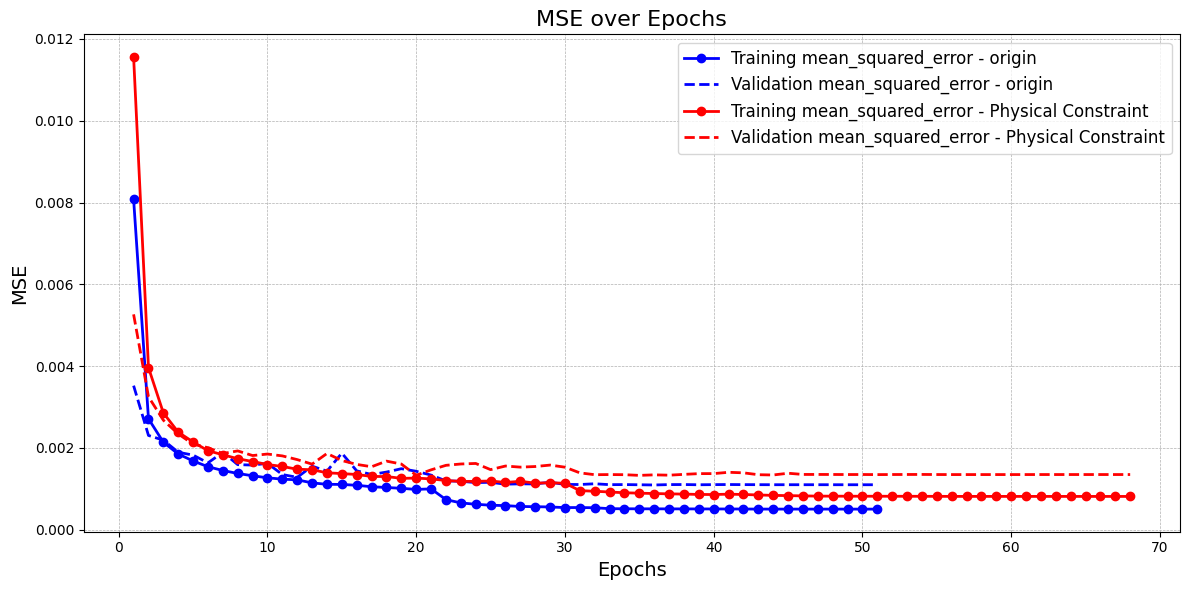

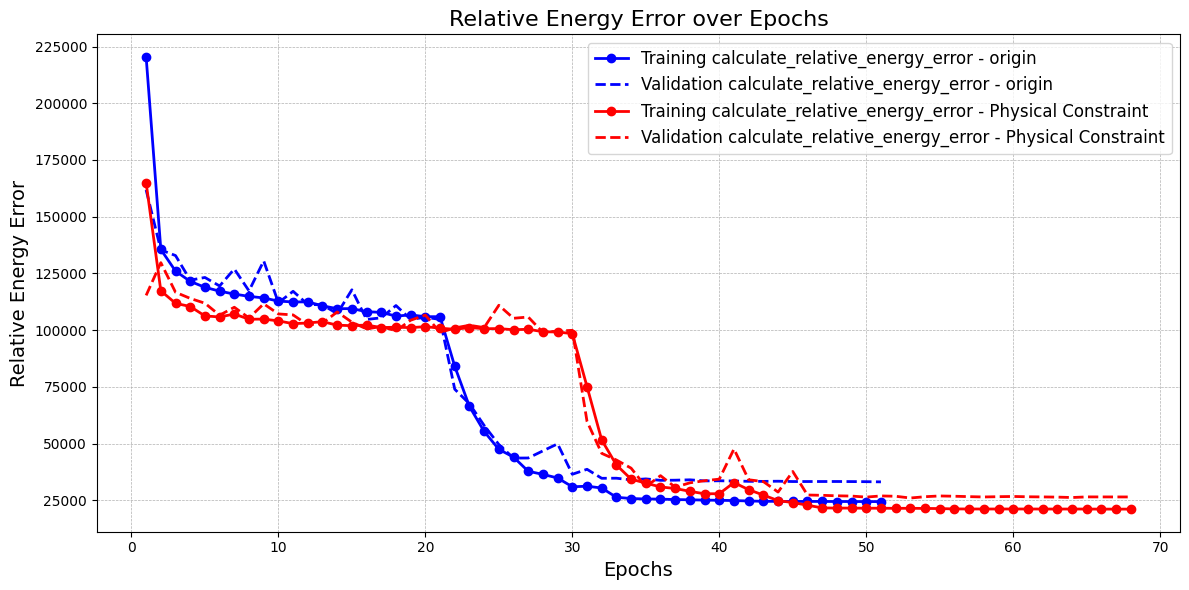

In [102]:
import matplotlib.pyplot as plt

def plot_metric(history1, history2, metric, title, ylabel):
    """
    Plot a specified metric from the training histories.
    """
    histories = [history1, history2]
    labels = ['orig_history', 'history']
    colors = ['b', 'r']

    for i, history in enumerate(histories):
        values = history.history[metric]
        val_values = history.history[f"val_{metric}"]

        epochs = range(1, len(values) + 1)

        # Plot training values
        plt.plot(epochs, values, f'{colors[i]}o-', label=f'Training {metric} - {labels[i]}')
        # Plot validation values
        plt.plot(epochs, val_values, f'{colors[i]}--', label=f'Validation {metric} - {labels[i]}')

    # Setting plot title and labels
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(ylabel)
    plt.legend()

    plt.show()
import matplotlib.pyplot as plt

def plot_metric(history1, history2, metric, title, ylabel):
    """
    Plot a specified metric from the training histories.
    """
    plt.figure(figsize=(12, 6))  # Set figure size
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)  # Add a grid for better readability
    plt.title(title, fontsize=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel(ylabel, fontsize=14)

    histories = [history1, history2]
    labels = ['origin', 'Physical Constraint']
    colors = ['b', 'r']

    for i, history in enumerate(histories):
        values = history.history[metric]
        val_values = history.history[f"val_{metric}"]

        epochs = range(1, len(values) + 1)

        # Plot training values with increased line width
        plt.plot(epochs, values, f'{colors[i]}o-', label=f'Training {metric} - {labels[i]}', linewidth=2)
        # Plot validation values with increased line width
        plt.plot(epochs, val_values, f'{colors[i]}--', label=f'Validation {metric} - {labels[i]}', linewidth=2)

    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()


# Plotting MSE
plot_metric(phy_history, real_phy_history, 'mean_squared_error', 'MSE over Epochs', 'MSE')

# Plotting calculate_relative_energy_error
plot_metric(phy_history, real_phy_history, 'calculate_relative_energy_error', 'Relative Energy Error over Epochs', 'Relative Energy Error')



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Assuming calculate_relative_energy_error and custom_loss are defined

def prepare_test_data(x_val, y_val, i):
    x_test_cu = x_val[290 + 300 * i:290 + 300 * i + 290, 0, :]
    y_test_cu = y_val[290 + 300 * i:290 + 300 * i + 290, 0, :]
    return x_test_cu, y_test_cu


def evaluate_models(i, x_val, y_val, orig_model, real_model):
    x_test_cu, y_test_cu = prepare_test_data(x_val, y_val, i)
    initial_input = x_test_cu[:10]

    forecasted_steps, mse = rolling_forecast(orig_model, initial_input, y_test_cu, len(y_test_cu))
    real_model_out, mse_phy = rolling_forecast(real_model, initial_input, y_test_cu, len(y_test_cu))

    average_mse_per_group = np.mean(mse, axis=1)
    average_mse_per_phy = np.mean(mse_phy, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(average_mse_per_phy[:], label='Physics-based MSE')
    plt.plot(average_mse_per_group[:], label='Original MSE')

    plt.title('Separate MSE over Steps')
    plt.xlabel('Step')
    plt.ylabel('MSE')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

# Load models
orig_model = tf.keras.models.load_model('/content/0121/orig_final_model.h5', custom_objects={
    'calculate_relative_energy_error': calculate_relative_energy_error,
})
real_model = tf.keras.models.load_model('/content/0121/ophy_final_model.h5', custom_objects={
    'custom_loss': custom_loss,
    'calculate_relative_energy_error': calculate_relative_energy_error,
})

# Example usage for i = 0 to 14
for i in range(15):
    evaluate_models(i, x_val, y_val, orig_model, real_model)


In [89]:
avg_mse_phy

0.099017635

1/1 [==============================] - 1s 620ms/step
(1, 10, 512)
1/1 [==============================] - 0s 20ms/step
(1, 10, 512)
1/1 [==============================] - 0s 25ms/step
(1, 10, 512)
1/1 [==============================] - 0s 29ms/step
(1, 10, 512)
1/1 [==============================] - 0s 21ms/step
(1, 10, 512)
1/1 [==============================] - 0s 19ms/step
(1, 10, 512)
1/1 [==============================] - 0s 18ms/step
(1, 10, 512)
1/1 [==============================] - 0s 18ms/step
(1, 10, 512)
1/1 [==============================] - 0s 18ms/step
(1, 10, 512)
1/1 [==============================] - 0s 18ms/step
(1, 10, 512)
1/1 [==============================] - 0s 18ms/step
(1, 10, 512)
1/1 [==============================] - 0s 18ms/step
(1, 10, 512)
1/1 [==============================] - 0s 18ms/step
(1, 10, 512)
1/1 [==============================] - 0s 17ms/step
(1, 10, 512)
1/1 [==============================] - 0s 18ms/step
(1, 10, 512)
1/1 [===================

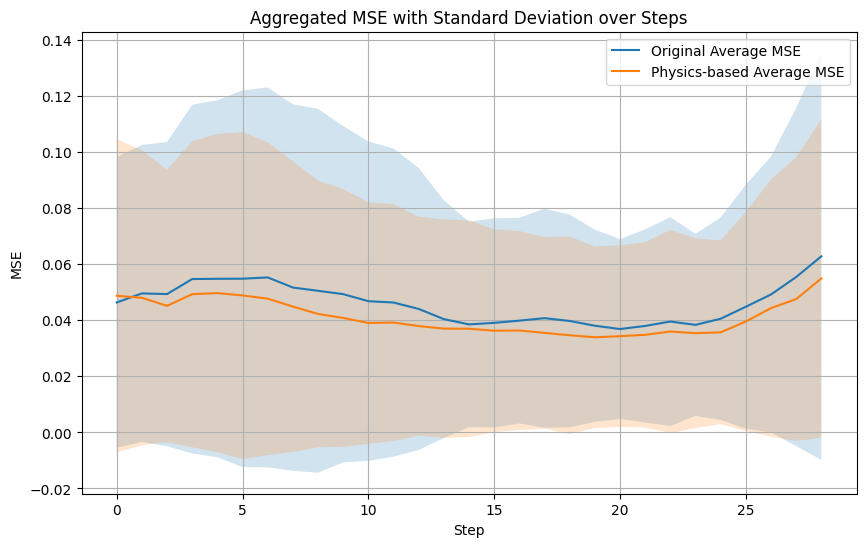

In [106]:
import numpy as np
import matplotlib.pyplot as plt
orig_model = tf.keras.models.load_model('/content/0121/orig_final_model.h5', custom_objects={
    'calculate_relative_energy_error':calculate_relative_energy_error,
})
real_model = tf.keras.models.load_model('/content/0121/ophy_final_model_42.h5', custom_objects={
    'custom_loss': custom_loss,
    'calculate_relative_energy_error':calculate_relative_energy_error,
})
def evaluate_models(i, x_val, y_val, orig_model, real_model):
    x_test_cu, y_test_cu = prepare_test_data(x_val, y_val, i)
    initial_input = x_test_cu[:10]

    _, mse = rolling_forecast(orig_model, initial_input, y_test_cu, len(y_test_cu))
    _, mse_phy = rolling_forecast(real_model, initial_input, y_test_cu, len(y_test_cu))

    return np.mean(mse), np.mean(mse_phy)

all_mse_orig = []
all_mse_phy = []

# 收集每个数据集的MSE
for i in range(14):
    x_test_cu, y_test_cu = prepare_test_data(x_val, y_val, i)
    initial_input = x_test_cu[:10]

    _, mse = rolling_forecast(orig_model, initial_input, y_test_cu, len(y_test_cu))
    _, mse_phy = rolling_forecast(real_model, initial_input, y_test_cu, len(y_test_cu))

    average_mse_per_group = np.mean(mse, axis=1)
    average_mse_per_phy = np.mean(mse_phy, axis=1)

    all_mse_orig.append(average_mse_per_group)
    all_mse_phy.append(average_mse_per_phy)

# 计算汇总的平均值和标准差
all_mse_orig = np.array(all_mse_orig)
all_mse_phy = np.array(all_mse_phy)

avg_mse_orig = np.mean(all_mse_orig, axis=0)
std_mse_orig = np.std(all_mse_orig, axis=0)

avg_mse_phy = np.mean(all_mse_phy, axis=0)
std_mse_phy = np.std(all_mse_phy, axis=0)

# 绘制汇总图表
plt.figure(figsize=(10, 6))
plt.plot(avg_mse_orig, label='Original Average MSE')
plt.fill_between(range(len(avg_mse_orig)), avg_mse_orig - std_mse_orig, avg_mse_orig + std_mse_orig, alpha=0.2)

plt.plot(avg_mse_phy, label='Physics-based Average MSE')
plt.fill_between(range(len(avg_mse_phy)), avg_mse_phy - std_mse_phy, avg_mse_phy + std_mse_phy, alpha=0.2)

plt.title('Aggregated MSE with Standard Deviation over Steps')
plt.xlabel('Step')
plt.ylabel('MSE')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


1/1 [==============================] - 0s 21ms/step
(1, 10, 512)
1/1 [==============================] - 0s 19ms/step
(1, 10, 512)
1/1 [==============================] - 0s 19ms/step
(1, 10, 512)
1/1 [==============================] - 0s 20ms/step
(1, 10, 512)
1/1 [==============================] - 0s 29ms/step
(1, 10, 512)
1/1 [==============================] - 0s 22ms/step
(1, 10, 512)
1/1 [==============================] - 0s 20ms/step
(1, 10, 512)
1/1 [==============================] - 0s 20ms/step
(1, 10, 512)
1/1 [==============================] - 0s 20ms/step
(1, 10, 512)
1/1 [==============================] - 0s 24ms/step
(1, 10, 512)
1/1 [==============================] - 0s 20ms/step
(1, 10, 512)
1/1 [==============================] - 0s 29ms/step
(1, 10, 512)
1/1 [==============================] - 0s 22ms/step
(1, 10, 512)
1/1 [==============================] - 0s 29ms/step
(1, 10, 512)
1/1 [==============================] - 0s 32ms/step
(1, 10, 512)
1/1 [====================

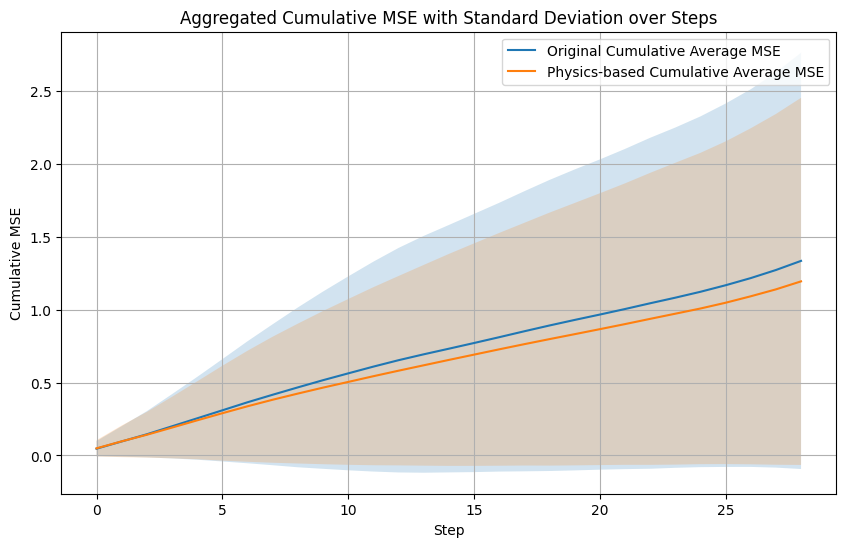

In [108]:

cumulative_mse_orig = []
cumulative_mse_phy = []

# 收集并计算每个数据集的累积MSE
for i in range(14):
    x_test_cu, y_test_cu = prepare_test_data(x_val, y_val, i)
    initial_input = x_test_cu[:10]

    _, mse = rolling_forecast(orig_model, initial_input, y_test_cu, len(y_test_cu))
    _, mse_phy = rolling_forecast(real_model, initial_input, y_test_cu, len(y_test_cu))

    cumulative_mse_per_group = np.cumsum(np.mean(mse, axis=1))
    cumulative_mse_per_phy = np.cumsum(np.mean(mse_phy, axis=1))

    cumulative_mse_orig.append(cumulative_mse_per_group)
    cumulative_mse_phy.append(cumulative_mse_per_phy)

# 计算汇总的平均值和标准差
cumulative_mse_orig = np.array(cumulative_mse_orig)
cumulative_mse_phy = np.array(cumulative_mse_phy)

avg_cumulative_mse_orig = np.mean(cumulative_mse_orig, axis=0)
std_cumulative_mse_orig = np.std(cumulative_mse_orig, axis=0)

avg_cumulative_mse_phy = np.mean(cumulative_mse_phy, axis=0)
std_cumulative_mse_phy = np.std(cumulative_mse_phy, axis=0)

# 绘制汇总图表
plt.figure(figsize=(10, 6))
plt.plot(avg_cumulative_mse_orig, label='Original Cumulative Average MSE')
plt.fill_between(range(len(avg_cumulative_mse_orig)), avg_cumulative_mse_orig - std_cumulative_mse_orig, avg_cumulative_mse_orig + std_cumulative_mse_orig, alpha=0.2)

plt.plot(avg_cumulative_mse_phy, label='Physics-based Cumulative Average MSE')
plt.fill_between(range(len(avg_cumulative_mse_phy)), avg_cumulative_mse_phy - std_cumulative_mse_phy, avg_cumulative_mse_phy + std_cumulative_mse_phy, alpha=0.2)

plt.title('Aggregated Cumulative MSE with Standard Deviation over Steps')
plt.xlabel('Step')
plt.ylabel('Cumulative MSE')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


In [81]:
i = 2
x_test_cu = x_val[290+300*i:290+300*i++290,0,:]
y_test_cu = y_val[290+300*i:290+300*i++290,0,:]

In [61]:
average_mse_per_phy

array([0.2326546 , 0.1993405 , 0.20651145, 0.22736788, 0.22762266,
       0.23634419, 0.22508144, 0.21241598, 0.21450272, 0.20023748,
       0.17497063, 0.16669193, 0.14311926, 0.13925491, 0.13937828,
       0.12949215, 0.1321406 , 0.13407192, 0.13977306, 0.13423812,
       0.12752628, 0.12655224, 0.13637705, 0.13467321, 0.12466554,
       0.15256497, 0.17559245, 0.20102818, 0.23968753], dtype=float32)

In [62]:
average_mse_per_group

array([0.2087501 , 0.20714942, 0.21138076, 0.24725266, 0.2570137 ,
       0.2687443 , 0.26881376, 0.26431516, 0.26372188, 0.23928635,
       0.22870147, 0.21945706, 0.19706164, 0.16863975, 0.14582416,
       0.14942776, 0.14461333, 0.15678538, 0.14860943, 0.13600227,
       0.12867215, 0.13632303, 0.1484964 , 0.1269915 , 0.14343433,
       0.17889641, 0.20171809, 0.24182066, 0.2905643 ], dtype=float32)

In [82]:
def rolling_forecast(model, initial_input, y_true, steps_to_predict):
    input_sequence = initial_input.reshape(1, -1, 512)  # Reshape to match LSTM input shape
    predictions = []
    mse_array = []

    for i in range(steps_to_predict // 10):  # Since we're considering 5 steps at a time
        next_steps = model.predict(input_sequence)
        print(next_steps.shape)
        next_steps_2d = next_steps.reshape(-1, 512)
        predictions.extend(next_steps_2d)

        mse = np.mean((next_steps_2d - y_true[10*i:10*(i+1)])**2, axis=1)  # Compute MSE for the current prediction block
        mse_array.append(mse)

        # Update the input sequence for the next prediction
        input_sequence = next_steps#np.concatenate((input_sequence[:, 10:, :], next_steps), axis=1)

    return np.array(predictions), np.array(mse_array)

orig_model = tf.keras.models.load_model('/content/0121/orig_final_model.h5', custom_objects={
    'calculate_relative_energy_error':calculate_relative_energy_error,
})
real_model = tf.keras.models.load_model('/content/0121/ophy_final_model.h5', custom_objects={
    'custom_loss': custom_loss,
    'calculate_relative_energy_error':calculate_relative_energy_error,
})
# Example usage:
initial_input = x_test_cu[:10]
forecasted_steps, mse = rolling_forecast(orig_model, initial_input, y_test_cu, len(y_test_cu))

real_model_out, mse_phy = rolling_forecast(real_model, initial_input, y_test_cu, len(y_test_cu))
average_mse_per_group = np.mean(mse, axis=1)
average_mse_per_phy = np.mean(mse_phy, axis=1)




1/1 [==============================] - 1s 628ms/step
(1, 10, 512)
1/1 [==============================] - 0s 19ms/step
(1, 10, 512)
1/1 [==============================] - 0s 20ms/step
(1, 10, 512)
1/1 [==============================] - 0s 19ms/step
(1, 10, 512)
1/1 [==============================] - 0s 19ms/step
(1, 10, 512)
1/1 [==============================] - 0s 20ms/step
(1, 10, 512)
1/1 [==============================] - 0s 20ms/step
(1, 10, 512)
1/1 [==============================] - 0s 19ms/step
(1, 10, 512)
1/1 [==============================] - 0s 19ms/step
(1, 10, 512)
1/1 [==============================] - 0s 19ms/step
(1, 10, 512)
1/1 [==============================] - 0s 19ms/step
(1, 10, 512)
1/1 [==============================] - 0s 20ms/step
(1, 10, 512)
1/1 [==============================] - 0s 19ms/step
(1, 10, 512)
1/1 [==============================] - 0s 19ms/step
(1, 10, 512)
1/1 [==============================] - 0s 19ms/step
(1, 10, 512)
1/1 [===================

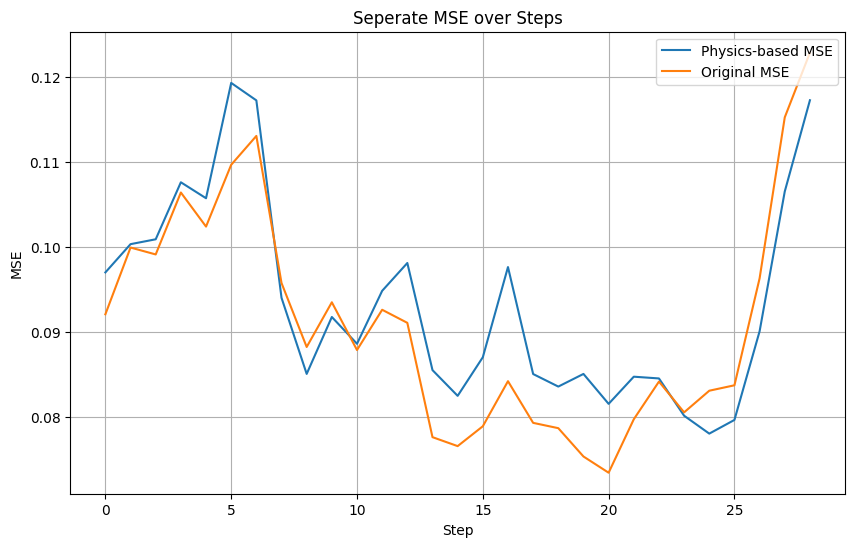

In [83]:
plt.figure(figsize=(10, 6))
plt.plot(average_mse_per_phy[:], label='Physics-based MSE')
plt.plot(average_mse_per_group[:], label='Original MSE')
#plt.plot(cumulative_mse_phy)  # 如果你想加入这个线，也确保为它添加一个label

plt.title('Seperate MSE over Steps')
plt.xlabel('Step')
plt.ylabel('MSE')
plt.legend(loc='upper right')  # 显示图例在右上角
plt.grid(True)
plt.show()


In [74]:
(true_image.shape[0]*0.1-10)

4490.0

In [76]:

orig_model = tf.keras.models.load_model('/content/0121/orig_final_model.h5', custom_objects={
    'calculate_relative_energy_error':calculate_relative_energy_error,
})
real_model = tf.keras.models.load_model('/content/0121/ophy_final_model.h5', custom_objects={
    'custom_loss': custom_loss,
    'calculate_relative_energy_error':calculate_relative_energy_error,
})
res_orig = orig_model.predict(x_val)
res_phy =real_model.predict(x_val)

res_orig = res_orig[:,0,:]
res_phy = res_phy[:,0,:]

#torig_res = scaler_auto.inverse_transform(res_orig)

reconstructed_images_phy = new_model.predict(res_phy)
reconstructed_images_orig = new_model.predict(res_orig)
num = 4490
true_test_lstm = true_image[-num:-10]


ssim_score = ssim(true_test_lstm, reconstructed_images_phy, multichannel=True)



140/140 [==============================] - 0s 1ms/step


<ipython-input-76-075004c0f538>:22: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_score = ssim(true_test_lstm, reconstructed_images_phy, multichannel=True)
/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


In [78]:
ssim_score_orig = ssim(true_test_lstm, reconstructed_images_orig, multichannel=True)
ssim_score_orig

<ipython-input-78-8ec911dd39be>:1: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_score_orig = ssim(true_test_lstm, reconstructed_images_orig, multichannel=True)
/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


In [79]:
ssim_score_orig

0.8781846742258409

In [77]:
ssim_score

0.8757914132187873

In [ ]:
# Calculate inference time
start_time = time.time()
res_phy = real_model.predict(x_val)
inference_time = time.time() - start_time

res_phy = res_phy[:,0,:]
reconstructed_images_phy = new_model.predict(res_phy)

true_test_lstm = true_image[-2390:-10]
# Assuming vor_test is your concatenated array with shape (n, 64, 64, 3)
# And vor_test_u_scaler, vor_test_v_scaler, vor_test_h_scaler are the scalers used for u, v, and h channels respectively

# Step 1: Separate the channels
vor_test_u = reconstructed_images_phy[:,:,:,0]
vor_test_v = reconstructed_images_phy[:,:,:,1]
vor_test_h = reconstructed_images_phy[:,:,:,2]

# Step 2: Inverse transform each channel
vor_test_u_original = vor_test_u * range_vu + min_vu
vor_test_v_original = vor_test_v * range_vv + min_vv
vor_test_h_original = vor_test_h * range_vh + min_vh

# Step 3: Recombine the channels
res_orign = np.stack([vor_test_u_original, vor_test_v_original, vor_test_h_original], axis=-1)

# Repeat the same steps for y_val if needed
vor_test_u = true_test_lstm[:,:,:,0]
vor_test_v = true_test_lstm[:,:,:,1]
vor_test_h = true_test_lstm[:,:,:,2]

vor_test_u_original = vor_test_u * range_vu + min_vu
vor_test_v_original = vor_test_v * range_vv + min_vv
vor_test_h_original = vor_test_h * range_vh + min_vh

# Recombine the channels
y_val = np.stack([vor_test_u_original, vor_test_v_original, vor_test_h_original], axis=-1)


res_orign = res_orign[:,:,:,:]
y_true = y_val[:, :, :, :]
res_orig_flat = res_orign.flatten()
y_true_flat = y_true.flatten()

from sklearn.metrics import mean_squared_error
mse_orig = mean_squared_error(res_orig_flat, y_true_flat)

ssim_score = ssim(y_true, res_orign, multichannel=True)

# Calculate RRMSE
rrmse = np.sqrt(mse_orig) / np.mean(y_true)


print("SSIM:", ssim_score)
print("RRMSE:", rrmse)
print("MSE_orig:", mse_orig)
print("Inference Time:", inference_time)

75/75 [==============================] - 0s 2ms/step


<ipython-input-62-c0a3332e7c78>:47: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_score = ssim(y_true, res_orign, multichannel=True)
/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


SSIM: 0.45529494780512386
RRMSE: 0.24794737210328197
MSE_orig: 0.009129211041754532
Inference Time: 0.36608290672302246


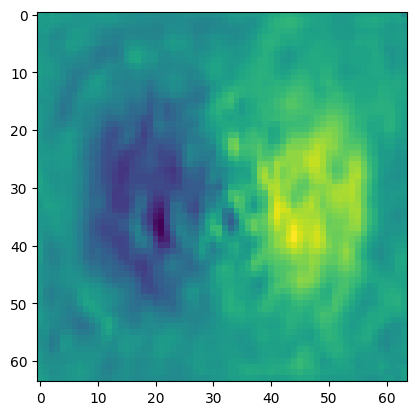

In [ ]:
plt.imshow(reconstructed_images_phy[300,:,:,0])

In [ ]:
#ssim_score_orig = ssim(true_test_lstm, reconstructed_images_orig,multichannel=True)
ssim_score_phy = ssim(true_test_lstm, reconstructed_images_phy,multichannel=True)

# Print the SSIM score
#print("The SSIM score orig is:", ssim_score_orig)
print("The SSIM score phy is:", ssim_score_phy)

<ipython-input-40-1eb110dfd76d>:2: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_score_phy = ssim(true_test_lstm, reconstructed_images_phy,multichannel=True)
/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


The SSIM score phy is: 0.9089115190579876


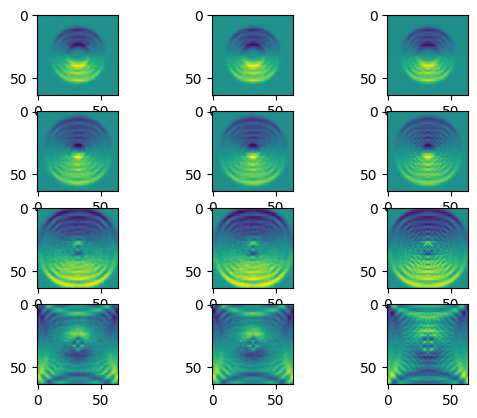

In [80]:

plt.subplot(4,3,1)
plt.imshow(reconstructed_images_phy[10,:,:,0])
plt.subplot(4,3,2)
plt.imshow(reconstructed_images_orig[10,:,:,0])
plt.subplot(4,3,3)
plt.imshow(true_test_lstm[10,:,:,0])
plt.subplot(4,3,4)
plt.imshow(reconstructed_images_phy[60,:,:,0])
plt.subplot(4,3,5)
plt.imshow(reconstructed_images_orig[60,:,:,0])
plt.subplot(4,3,6)
plt.imshow(true_test_lstm[60,:,:,0])
plt.subplot(4,3,7)
plt.imshow(reconstructed_images_phy[110,:,:,0])
plt.subplot(4,3,8)
plt.imshow(reconstructed_images_orig[110,:,:,0])
plt.subplot(4,3,9)
plt.imshow(true_test_lstm[110,:,:,0])
plt.subplot(4,3,10)
plt.imshow(reconstructed_images_phy[200,:,:,0])
plt.subplot(4,3,11)
plt.imshow(reconstructed_images_orig[200,:,:,0])
plt.subplot(4,3,12)
plt.imshow(true_test_lstm[220,:,:,0])

Displaying images for index: 250


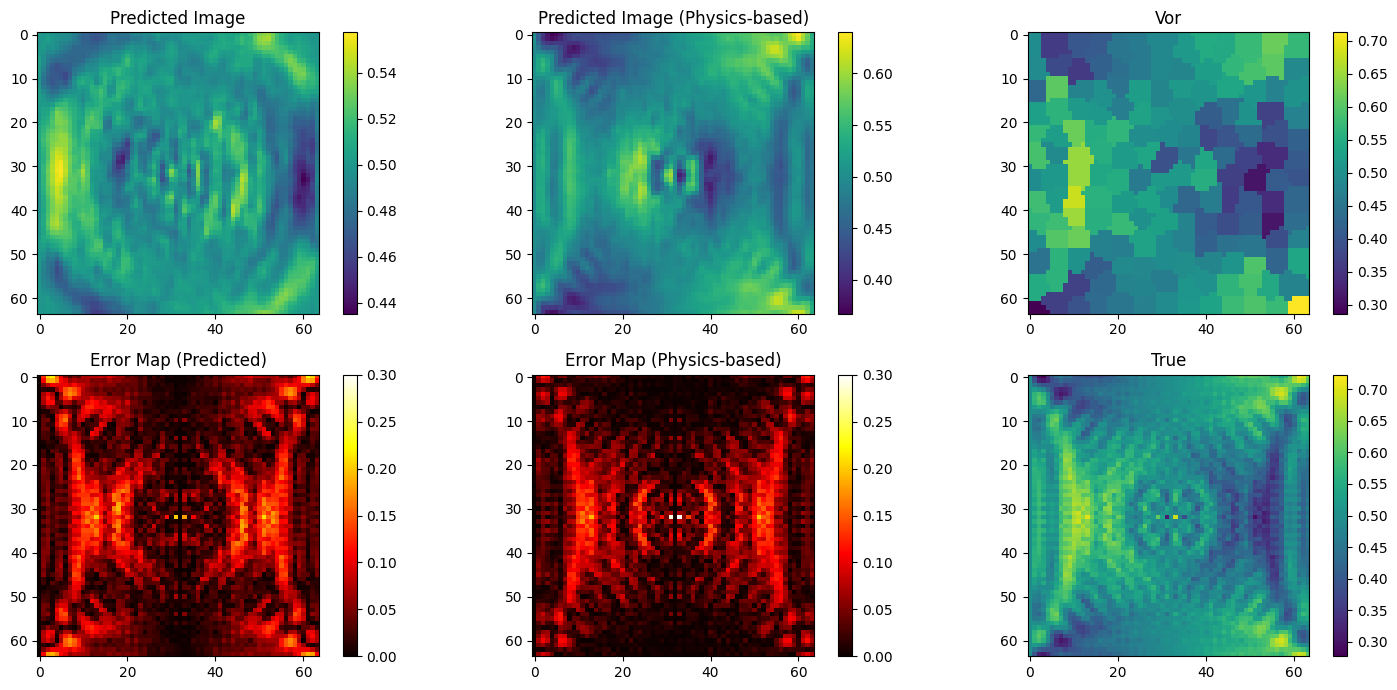

Displaying images for index: 270


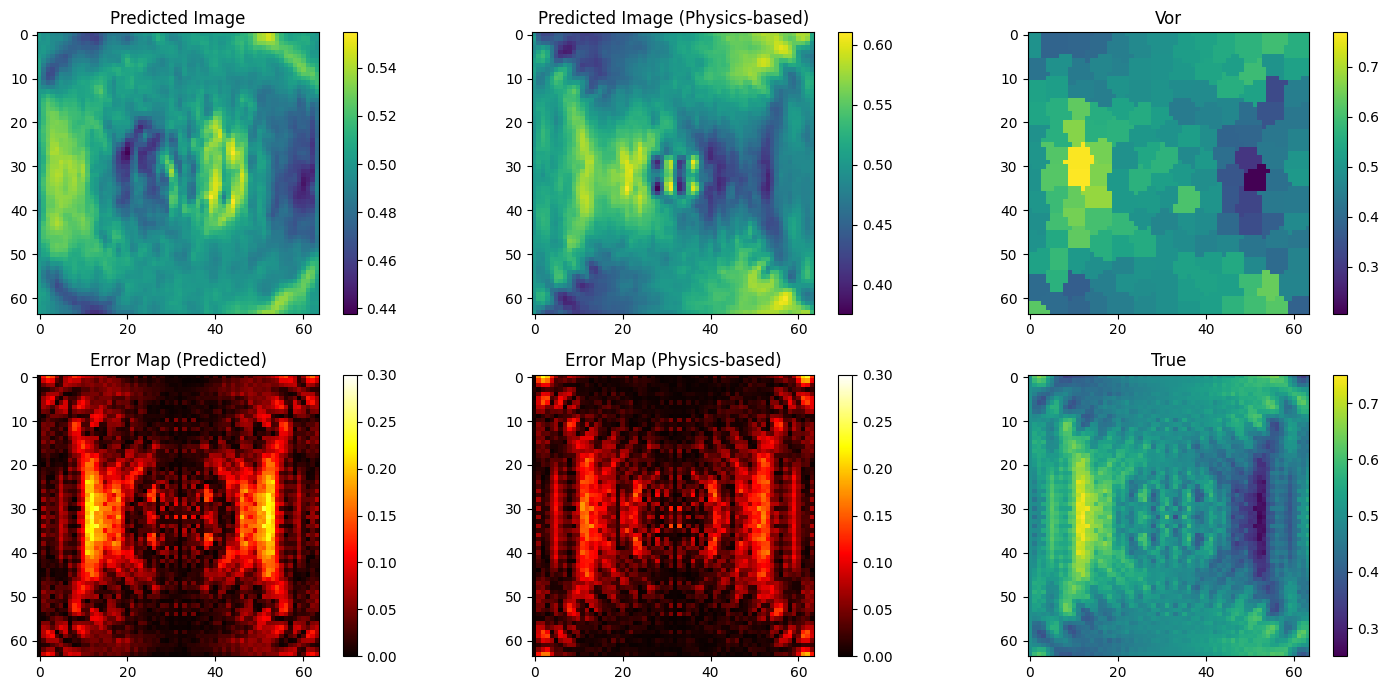

In [ ]:
def plot_error_map(predicted, predicted_phy, true,vor):
    """
    Plots the predicted image, physics-based predicted image, true image,
    and the error maps between predicted/physics-predicted and true images.

    Parameters:
    - predicted: Predicted image
    - predicted_phy: Physics-based predicted image
    - true: True image
    """

    error_map = np.abs(predicted - true)
    error_map_phy = np.abs(predicted_phy - true)

    plt.figure(figsize=(15,7))

    # Plot the Predicted Image
    plt.subplot(2,3,1)
    plt.imshow(predicted)
    plt.title("Predicted Image")
    plt.colorbar()

    # Plot the Physics-based Predicted Image
    plt.subplot(2,3,2)
    plt.imshow(predicted_phy)
    plt.title("Predicted Image (Physics-based)")
    plt.colorbar()

    # Plot the Physics-based Predicted Image
    plt.subplot(2,3,3)
    plt.imshow(vor)
    plt.title("Vor")
    plt.colorbar()

    # Plot the Error Map for Predicted Image
    plt.subplot(2,3,4)
    plt.imshow(error_map, cmap='hot', vmin=0, vmax=0.3)
    plt.title("Error Map (Predicted)")
    plt.colorbar()

    # Plot the Error Map for Physics-based Predicted Image
    plt.subplot(2,3,5)
    plt.imshow(error_map_phy, cmap='hot', vmin=0, vmax=0.3)
    plt.title("Error Map (Physics-based)")
    plt.colorbar()

    # Plot the Error Map for Physics-based Predicted Image
    plt.subplot(2,3,6)
    plt.imshow(true)
    plt.title("True")
    plt.colorbar()
    plt.tight_layout()
    plt.show()

indices_to_display = np.linspace(250, 270, 2, dtype=int)  # 从数据中选择10个索引

for idx in indices_to_display:
    print(f"Displaying images for index: {idx}")
    plot_error_map(reconstructed_images_orig[idx,:,:,0],
                   reconstructed_images_phy[idx,:,:,0],
                   true_test_lstm[idx,:,:,0],
                   vor_test_lstm[idx,:,:,0])


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


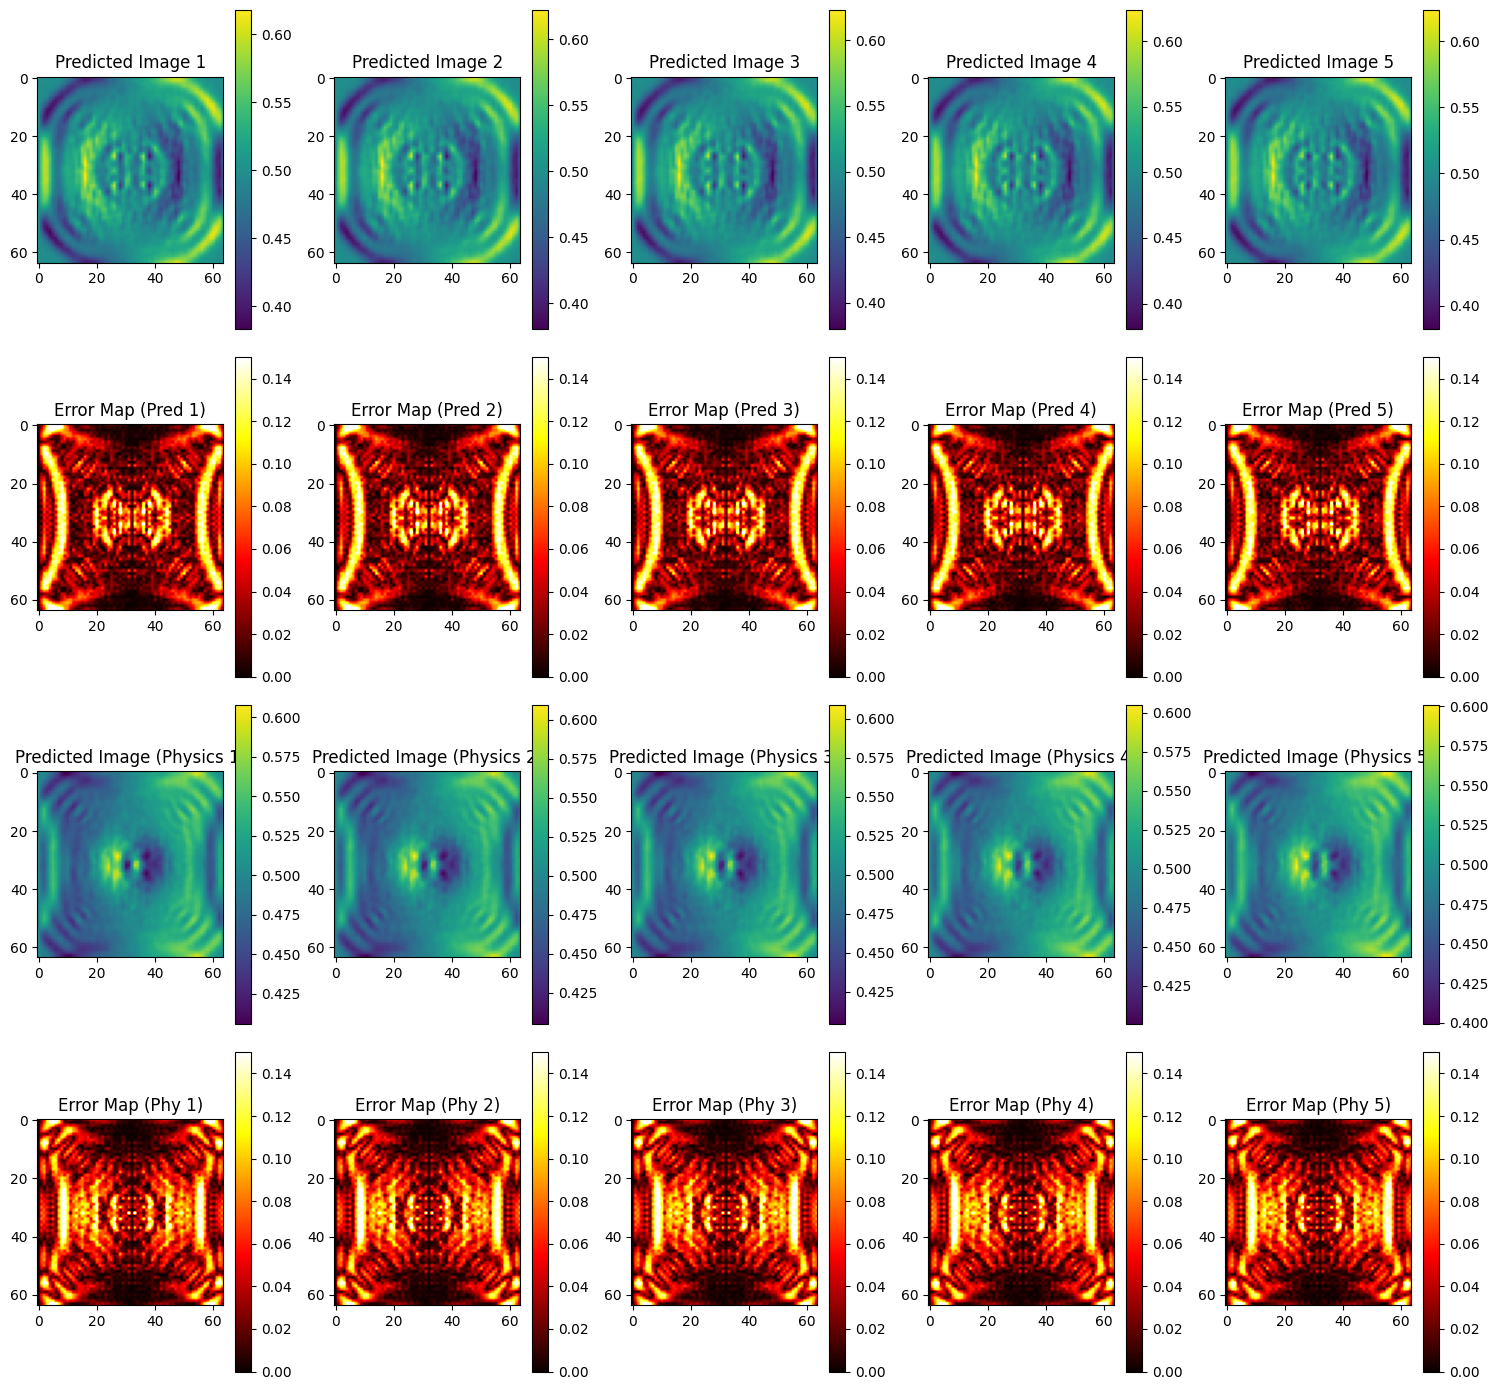

In [ ]:
import matplotlib.colors as mcolors


colors = [(0, 0, 1), (1, 1, 1), (1, 0, 0)]  # R -> White -> B
cmap_name = 'custom_div_cmap'
cm = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors, N=100)


def plot_error_map(predicted, predicted_phy, true):
    """
    Plots the predicted images, physics-based predicted images, true images,
    and the error maps between predicted/physics-predicted and true images.

    Parameters:
    - predicted: List of 5 Predicted images
    - predicted_phy: List of 5 Physics-based predicted images
    - true: List of 5 True images
    """

    plt.figure(figsize=(15,14))

    # Ensure the inputs are lists of images and not single images
    assert len(predicted) == 5
    assert len(predicted_phy) == 5
    assert len(true) == 5

    for i in range(5):
        # Compute error maps
        error_map = np.abs(predicted[i] - true[i])
        error_map_phy = np.abs(predicted_phy[i] - true[i])

        # 1st row: Predicted images
        plt.subplot(4, 5, i + 1)
        plt.imshow(predicted[i])
        plt.title(f"Predicted Image {i+1}")
        plt.colorbar()

        # 2nd row: Error maps for Predicted images
        plt.subplot(4, 5, i + 6)
        plt.imshow(error_map, cmap='hot', vmin=0, vmax=0.15)
        plt.title(f"Error Map (Pred {i+1})")
        plt.colorbar()

        # 3rd row: Physics-based Predicted images
        plt.subplot(4, 5, i + 11)
        plt.imshow(predicted_phy[i])
        plt.title(f"Predicted Image (Physics {i+1})")
        plt.colorbar()

        # 4th row: Error maps for Physics-based Predicted images
        plt.subplot(4, 5, i + 16)
        plt.imshow(error_map_phy, cmap='hot', vmin=0, vmax=0.15)
        plt.title(f"Error Map (Phy {i+1})")
        plt.colorbar()

    plt.tight_layout()
    plt.show()


idx = 230
predicted_group = [reconstructed_images_orig[i,:,:,0] for i in range(idx, idx + 5)]
predicted_phy_group = [reconstructed_images_phy[i,:,:,0] for i in range(idx, idx + 5)]
true_group = [true_test_lstm[i,:,:,0] for i in range(idx, idx + 5)]

plot_error_map(predicted_group, predicted_phy_group, true_group)

In [ ]:
true_test_lstm.shape

(2390, 64, 64, 3)

In [ ]:
from skimage.metrics import structural_similarity as ssim

# Compute SSIM between the two images

ssim_score_orig = ssim(true_test_lstm, reconstructed_images_orig,multichannel=True)
ssim_score_phy = ssim(true_test_lstm, reconstructed_images_phy,multichannel=True)

# Print the SSIM score
print("The SSIM score orig is:", ssim_score_orig)
print("The SSIM score phy is:", ssim_score_phy)


# Flatten the image sets to size (7500, 12288)
flat_set_true = true_test_lstm.reshape((1190, -1))
flat_set_orig = reconstructed_images_orig.reshape((1190, -1))
flat_set_phy = reconstructed_images_phy.reshape((1190, -1))

# Compute the L2 norm between the two flattened sets
diff_vectors_orig = flat_set_true - flat_set_orig
diff_vectors_phy = flat_set_true - flat_set_phy

l2_norms_orig = np.linalg.norm(diff_vectors_orig, axis=1)
l2_norms_phy = np.linalg.norm(diff_vectors_phy, axis=1)


relative_errors_orig = l2_norms_orig / np.linalg.norm(flat_set_true, axis=1)
relative_errors_phy = l2_norms_phy / np.linalg.norm(flat_set_true, axis=1)

mean_relative_error_orig = np.mean(relative_errors_orig)
mean_relative_error_phy = np.mean(relative_errors_phy)


# Print the L2 norm error
print("The L2 norm error orig is:", mean_relative_error_orig)
print("The L2 norm error phy is:", mean_relative_error_phy)

<ipython-input-67-4b4e474d8e24>:5: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_score_orig = ssim(true_test_lstm, reconstructed_images_orig,multichannel=True)
<ipython-input-67-4b4e474d8e24>:6: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_score_phy = ssim(true_test_lstm, reconstructed_images_phy,multichannel=True)


The SSIM score orig is: 0.8086626413936356
The SSIM score phy is: 0.8053506309938703
The L2 norm error orig is: 0.11896717326702691
The L2 norm error phy is: 0.11929783034524057


# ConvAutoencoder + Conv

In [ ]:
vor_train = np.load('/content/vor_train.npy', mmap_mode="r")
true_train = np.load('/content/true_train.npy', mmap_mode="r")
vor_test = np.load('/content/vor_test.npy', mmap_mode="r")
true_test = np.load('/content/true_test.npy', mmap_mode="r")

In [ ]:
def encoder_f(input_img, n):
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Flatten()(x)
    x = Dense(n, activation='relu', name='encoded')(x)
    return Model(inputs=input_img, outputs=x), x

def decoder_f(encoded_img):
    x = Dense(8*8*128, activation='relu')(encoded_img)
    x = Reshape((8, 8, 128))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)

    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same', name='decoded')(x)
    return Model(inputs=encoded_img, outputs=decoded), decoded


In [ ]:
auto_input = Input(shape=(64,64,3))
encoded, x = encoder_f(auto_input,256)
decoded, decode_output = decoder_f(x)
autoencoder = Model(auto_input, decode_output)
autoencoder.compile(optimizer='rmsprop', loss='mse')
autoencoder.summary()

In [ ]:
start_time = time.time()
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="loss", patience=10)
history = autoencoder.fit(true_train, true_train, epochs=50,batch_size=16,callbacks=(early_stopping,reduce_lr),validation_data = (true_test,true_test),shuffle=True)
end_time = time.time()

total_time_trls = start_time - end_time

In [ ]:
# create a new model that outputs the encoded features
encoder_model_true = Model(inputs=auto_input, outputs=x)

# use the encoder to get the encoded features
encoded_true = encoder_model_true.predict(true_test)


In [ ]:
#encoded = norm_auto(encoded_features)
scaler_true = MinMaxScaler()
encoder_true = scaler_true.fit_transform(encoded_true)

In [ ]:
def vor2latent(vor_input, n):
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(vor_input)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Flatten()(x)
    x = Dense(n, activation='relu', name='encoded')(x)
    return Model(inputs=vor_input, outputs=x), x

In [ ]:
#n = res_true.shape[1]
n = 256
vor_input = Input(shape=(64,64,3))
encoder, x = vor2latent(vor_input,n)

encoder.compile(optimizer='rmsprop', loss='mse')
encoder.summary()

In [ ]:
#early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
#reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)
history = encoder.fit(vor_test, encoded_true, epochs=70,batch_size=4,shuffle=True)

In [ ]:
res_cnn = encoder.predict(vor_test)

1. try different latent space
2. increase dataset size
3. add tricks into models
4. baseline LSTM-256 (256,3) 2000,compare to conv 256
5. compare images similarity usinf SSIM

Make slides and summary of res LSIM
5. 5 2 5, pred input's total energy，pred's total energy (compare to real energy)

In [ ]:
cnn_scaler = MinMaxScaler()
res_cnn = cnn_scaler.fit_transform(res_cnn)

In [ ]:

x_train_cnn,x_test_cnn = train_test_split(res_cnn,test_size=0.2)
x_train = np.array([x_train_cnn[i:i+4,:] for i in range(len(x_train_cnn)-4)])
x_test = np.array([x_test_cnn[i:i+4,:,] for i in range(len(x_test_cnn)-4)])


def create_shifted_frames(data, n_frames):
    x = data[0 : data.shape[0] - n_frames]
    y = data[n_frames : data.shape[0]]
    return x, y

# Apply the processing function to the datasets.
x_train, y_train = create_shifted_frames(x_train,4)
x_val, y_val = create_shifted_frames(x_test,4)
x_train.shape

In [ ]:
x_train

In [ ]:

# Build the model
model = Sequential()
model.add(LSTM(128, input_shape=(4, 256)))
model.add(RepeatVector(4))
model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(256)))
model.add(Activation('sigmoid'))

# Compile the model
model.compile(loss='mse', optimizer='rmsprop')

# Print the model summary
model.summary()

In [ ]:
start_time = time.time()
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="loss", patience=10)
history = model.fit(x_train, y_train, epochs=50,batch_size=16,callbacks=(early_stopping,reduce_lr),validation_data = (x_val,y_val),shuffle=True)
end_time = time.time()

total_time_cnn = start_time - end_time